In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load processed datasets
train_df = pd.read_csv('../Data/processed/train_processed.csv')
test_df = pd.read_csv('../Data/processed/test_processed.csv')

print("✓ Datasets loaded successfully!")
print(f"  - Train shape: {train_df.shape}")
print(f"  - Test shape: {test_df.shape}")

# Separate features (X) and target (y) from training data
X = train_df.drop('sii', axis=1)  # Features
y = train_df['sii']                # Target variable

print(f"\n✓ Data prepared!")
print(f"  - X (features): {X.shape}")
print(f"  - y (target): {y.shape}")

# Split into train and validation (use validation as "test" for evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for validation/testing
    random_state=42,    # For reproducibility
    stratify=y          # Maintain class distribution
)

print(f"\n✓ Train/Validation split completed!")
print(f"  - X_train: {X_train.shape}")
print(f"  - X_test (validation): {X_test.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - y_test (validation): {y_test.shape}")

# Display target distribution
print(f"\n📊 Target distribution:")
print(f"  - Training set:\n{y_train.value_counts().sort_index()}")
print(f"\n  - Test/Validation set:\n{y_test.value_counts().sort_index()}")

# Note: test_df from Kaggle has no labels (for final submission)
X_submission = test_df.copy()
print(f"\n📁 Kaggle submission data: {X_submission.shape} (no labels)")

✓ Datasets loaded successfully!
  - Train shape: (2736, 181)
  - Test shape: (20, 158)

✓ Data prepared!
  - X (features): (2736, 180)
  - y (target): (2736,)

✓ Train/Validation split completed!
  - X_train: (2188, 180)
  - X_test (validation): (548, 180)
  - y_train: (2188,)
  - y_test (validation): (548,)

📊 Target distribution:
  - Training set:
sii
0.0    1275
1.0     584
2.0     302
3.0      27
Name: count, dtype: int64

  - Test/Validation set:
sii
0.0    319
1.0    146
2.0     76
3.0      7
Name: count, dtype: int64

📁 Kaggle submission data: (20, 158) (no labels)


In [ ]:
import os

out_dir = os.path.join('..', 'Data', 'processed')
os.makedirs(out_dir, exist_ok=True)

source
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
sns.set(style="whitegrid")

# Path to raw dataset (only raw will be used)
raw_path = r"d:\\HỌC KỲ V\\Chuẩn bị dữ liệu và Visualization\\Project_final\\Data\\processed\\test_cleaned.csv"

# Read raw CSV
df = pd.read_csv(raw_path).copy()

# Create and clean subgroup columns
# Age group: child <13, adolescent >=13, unknown if missing
df['age'] = df.get('Basic_Demos-Age')
df['age_group'] = df['age'].apply(lambda x: 'child' if pd.notnull(x) and x < 13 else ('adolescent' if pd.notnull(x) else 'unknown'))
# Sex mapping: 0->Male, 1->Female, else Unknown
df['sex'] = df.get('Basic_Demos-Sex').map({0: 'Male', 1: 'Female'}) if 'Basic_Demos-Sex' in df.columns else None
if 'sex' in df.columns:
    df['sex'] = df['sex'].fillna('Unknown')
else:
    df['sex'] = 'Unknown'
# Enroll season (as-is)
df['enroll_season'] = df.get('Basic_Demos-Enroll_Season').astype(str).replace('nan', 'Unknown') if 'Basic_Demos-Enroll_Season' in df.columns else 'Unknown'
# BMI groups from BIA-BIA_BMI if available
if 'BIA-BIA_BMI' in df.columns:
    df['bmi'] = df['BIA-BIA_BMI']
    def bmi_cat(x):
        try:
            if pd.isna(x):
                return 'Unknown'
        except Exception:
            return 'Unknown'
        try:
            xv = float(x)
        except Exception:
            return 'Unknown'
        if xv < 18.5:
            return 'Underweight'
        elif xv < 25:
            return 'Normal'
        elif xv < 30:
            return 'Overweight'
        else:
            return 'Obese'
    df['bmi_group'] = df['bmi'].apply(bmi_cat)
else:
    df['bmi_group'] = 'Unknown'

# sii positive indicator (sii >= 1)
df['sii_pos'] = (df.get('sii', pd.Series([np.nan]*len(df))) >= 1).astype(int)

# List of subgroup columns to plot (display order key -> column name)
subgroups = {
    'Age group': 'age_group',
    'Sex': 'sex',
    'Enroll season': 'enroll_season',
    'BMI group': 'bmi_group',
}

# Compute rates for each subgroup and plot (one subplot per subgroup)
results = {}
for name, col in subgroups.items():
    if col not in df.columns:
        results[name] = pd.DataFrame(columns=[col, 'rate', 'n'])
        continue
    grp = df.groupby(col)['sii_pos'].agg(['mean', 'count']).reset_index().rename(columns={'mean':'rate','count':'n'})
    # Sort by rate descending for plotting
    grp = grp.sort_values('rate', ascending=False)
    results[name] = grp

# Plotting layout
n_plots = len(subgroups)
ncols = 2
nrows = (n_plots + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = np.array(axes).reshape(-1)

for ax_idx, (name, col) in enumerate(subgroups.items()):
    ax = axes[ax_idx]
    grp = results[name]
    if grp.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_axis_off()
        continue
    labels = grp[col].astype(str).tolist()
    rates = grp['rate'].fillna(0).tolist()
    counts = grp['n'].tolist()
    sns.barplot(x=rates, y=labels, ax=ax, palette='Blues_d')
    ax.set_xlim(0, 1)
    ax.set_xlabel('Proportion (sii >= 1)')
    ax.set_ylabel(name)
    ax.set_title(f'sii >= 1 by {name} (Raw)')
    for i, (r, c) in enumerate(zip(rates, counts)):
        xpos = r + 0.02 if r < 0.9 else r - 0.18
        ax.text(xpos, i, f'{r:.1%} (n={int(c)})', va='center', color='black', fontsize=9)

# Hide any unused subplots
for j in range(len(subgroups), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Display numeric tables for each subgroup for reference
for name, grp in results.items():
    print(f'--- {name} ---')
    display(grp)


Saved files to: ..\Data\processed
 - X_submission.csv
 - train_splitted.csv
 - test_splitted.csv


In [62]:
# Remove PCIAT-related features (internet addiction questionnaire)
print("🔍 Removing PCIAT features...")

# Find all columns that contain 'PCIAT' in their names
pciat_cols = [col for col in X_train.columns if 'PCIAT' in col.upper()]

if pciat_cols:
    print(f"⚠️  Found {len(pciat_cols)} PCIAT-related columns:")
    print(f"   {pciat_cols[:5]}..." if len(pciat_cols) > 5 else f"   {pciat_cols}")
    print("\n🗑️  Removing PCIAT features (too directly related to internet use)...")
    
    # Remove PCIAT columns from both train and test
    X_train = X_train.drop(columns=pciat_cols)
    X_test = X_test.drop(columns=pciat_cols)
    
    print(f"✓ Removed {len(pciat_cols)} PCIAT features")
else:
    print("✓ No PCIAT features found")

print(f"\n✓ Data shape after removing PCIAT:")
print(f"  - X_train: {X_train.shape}")
print(f"  - X_test: {X_test.shape}")

🔍 Removing PCIAT features...
⚠️  Found 28 PCIAT-related columns:
   ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05']...

🗑️  Removing PCIAT features (too directly related to internet use)...
✓ Removed 28 PCIAT features

✓ Data shape after removing PCIAT:
  - X_train: (2188, 139)
  - X_test: (548, 139)


In [63]:
X_train.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,weekday_75%,weekday_max,quarter_count,quarter_mean,quarter_std,quarter_min,quarter_25%,quarter_50%,quarter_75%,quarter_max
889,5,0,55.0,17.219160,45.0,49.6,NaN,84.0,99.0,135.0,...,7.0,7.0,54973.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
2641,12,1,40.0,33.760094,62.0,184.6,NaN,76.0,73.0,128.0,...,6.0,7.0,66911.0,1.018114,0.133363,1.0,1.0,1.0,1.0,2.0
867,15,0,85.0,20.856713,66.5,131.2,27.0,59.0,66.0,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,12,1,NaN,19.700639,65.0,118.4,NaN,69.0,66.0,104.0,...,6.0,7.0,380688.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
34,17,0,80.0,21.105405,74.0,164.4,NaN,68.0,83.0,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
import time

# Initialize XGBoost model with DEFAULT parameters
print("🚀 Training XGBoost model (default parameters)...")
start_time = time.time()

xgb_model = XGBClassifier(
    objective='multi:softprob',  # Multi-class classification
    num_class=4,                # 4 classes (SII: 0, 1, 2, 3)
    eval_metric='mlogloss',     # Multi-class log loss
    n_estimators=100,           # Number of trees
    max_depth=6,                # Tree depth (default)
    learning_rate=0.05,          # Learning rate (default)
    random_state=42,            # Reproducibility
    n_jobs=-1                   # Use all CPU cores
)

# Train the model
xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Import classification metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# ========================================
# TRAINING SET METRICS
# ========================================
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
train_f1 = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
train_qwk = cohen_kappa_score(y_train, y_pred_train, weights='quadratic')

print(f"\n📊 Training Set Performance:")
print(f"  - Accuracy:  {train_accuracy:.4f}")
print(f"  - Precision: {train_precision:.4f}")
print(f"  - Recall:    {train_recall:.4f}")
print(f"  - F1-Score:  {train_f1:.4f}")
print(f"  - QWK:       {train_qwk:.4f}")

# ========================================
# TEST/VALIDATION SET METRICS
# ========================================
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
test_qwk = cohen_kappa_score(y_test, y_pred_test, weights='quadratic')

print(f"\n📊 Test/Validation Set Performance:")
print(f"  - Accuracy:  {test_accuracy:.4f}")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall:    {test_recall:.4f}")
print(f"  - F1-Score:  {test_f1:.4f}")
print(f"  - QWK:       {test_qwk:.4f} ⭐ (Kaggle metric)")

# ========================================
# CLASSIFICATION REPORT
# ========================================
print(f"\n📋 Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test, 
                          target_names=['SII=0', 'SII=1', 'SII=2', 'SII=3'],
                          zero_division=0))

# Confusion Matrix
print(f"\n🔢 Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_test))

# ========================================
# METRIC EXPLANATIONS
# ========================================
print(f"\n💡 Metric Explanations:")
print(f"   • Accuracy:  % of correct predictions overall")
print(f"   • Precision: % of predicted positives that are actually positive")
print(f"   • Recall:    % of actual positives that are correctly predicted")
print(f"   • F1-Score:  Harmonic mean of Precision and Recall")
print(f"   • QWK:       Quadratic Weighted Kappa (Kaggle competition metric)")
print(f"              Measures agreement, penalizes larger errors more")

🚀 Training XGBoost model (default parameters)...
✓ Training completed in 3.96 seconds

📊 Training Set Performance:
  - Accuracy:  0.9068
  - Precision: 0.9113
  - Recall:    0.9068
  - F1-Score:  0.9043
  - QWK:       0.8690

📊 Test/Validation Set Performance:
  - Accuracy:  0.6040
  - Precision: 0.5619
  - Recall:    0.6040
  - F1-Score:  0.5709
  - QWK:       0.3390 ⭐ (Kaggle metric)

📋 Classification Report (Test Set):
              precision    recall  f1-score   support

       SII=0       0.68      0.85      0.75       319
       SII=1       0.41      0.29      0.34       146
       SII=2       0.36      0.18      0.24        76
       SII=3       0.60      0.43      0.50         7

    accuracy                           0.60       548
   macro avg       0.51      0.44      0.46       548
weighted avg       0.56      0.60      0.57       548


🔢 Confusion Matrix (Test Set):
[[271  36  11   1]
 [ 89  43  14   0]
 [ 38  23  14   1]
 [  1   3   0   3]]

💡 Metric Explanations:
   • A

In [65]:
from sklearn.metrics import confusion_matrix

labels = [0, 1, 2, 3]
cm = confusion_matrix(y_test, y_pred, labels=labels)

tp = np.diag(cm)
support = cm.sum(axis=1)
recall = tp / support
fn_rate = 1 - recall   # false negative rate
classes = ['SII = 0 (None)', 'SII = 1 (Mild)',
           'SII = 2 (Moderate)', 'SII = 3 (Severe)']

In [66]:
base_blue   = '#B3E5FC'  # light, fresh
accent_blue = '#0288D1'  # highlight
correct_col = '#455A64'  # dark blue-grey
missed_col  = '#FF7043'  # warm coral

In [67]:
# Common palette for all plots
grey_line    = '#E0E0E0'
grey_fill    = '#D0D0D0'
grey_text    = '#9E9E9E'

accent_line  = '#B3E5FC'
accent_fill  = '#0288D1'
accent_text  = '#01579B'

correct_col = '#2C7BB6'  # soft but clear blue for "Correct"
missed_col  = '#D73027'  # strong red for "Missed" (errors)


In [68]:
from sklearn.metrics import confusion_matrix
import numpy as np

labels = [0, 1, 2, 3]
cm = confusion_matrix(y_test, y_pred, labels=labels)

tp = np.diag(cm)
support = cm.sum(axis=1)
recall = tp / support
fn_rate = 1 - recall

classes = ['SII = 0 (None)',
           'SII = 1 (Mild)',
           'SII = 2 (Moderate)',
           'SII = 3 (Severe)']
x = np.arange(len(classes))


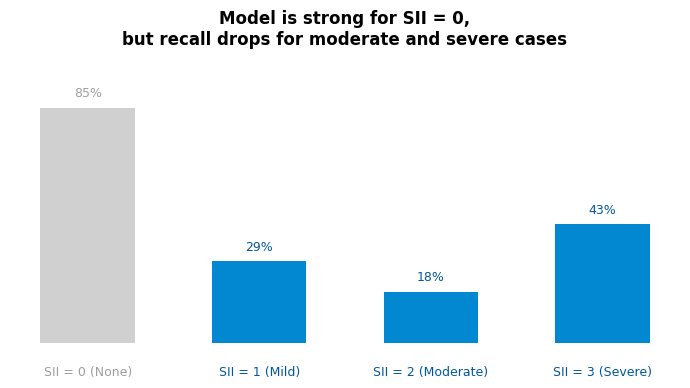

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

colors = [grey_fill, accent_fill, accent_fill, accent_fill]

bars = ax.bar(x, recall, color=colors, width=0.55)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.set_ylim(0, 1.05)

ax.set_title(
    'Model is strong for SII = 0,\n'
    'but recall drops for moderate and severe cases',
    fontsize=12, fontweight='bold'
)

for idx, (xi, cls, val) in enumerate(zip(x, classes, recall)):
    text_color = grey_text if idx < 1 else accent_text
    ax.text(xi, -0.08, cls,
            ha='center', va='top', fontsize=9, color=text_color)
    ax.text(xi, val + 0.03, f'{val:.0%}',
            ha='center', va='bottom', fontsize=9, color=text_color)

plt.tight_layout()
plt.show()


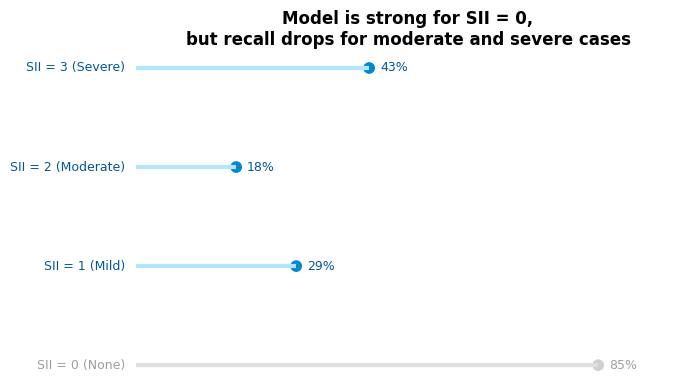

In [70]:
fig, ax = plt.subplots(figsize=(7, 4))

y_pos = np.arange(len(classes))

for idx, (r, y) in enumerate(zip(recall, y_pos)):
    if idx < 1:
        ax.hlines(y=y, xmin=0, xmax=r, color=grey_line, linewidth=3)
    else:
        ax.hlines(y=y, xmin=0, xmax=r, color=accent_line, linewidth=3)

point_colors = [grey_fill, accent_fill, accent_fill, accent_fill]
ax.scatter(recall, y_pos, color=point_colors, s=55)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)

ax.set_xlim(0, 1.0)
ax.set_title(
    'Model is strong for SII = 0,\n'
    'but recall drops for moderate and severe cases',
    fontsize=12, fontweight='bold'
)

for idx, (r, y, cls) in enumerate(zip(recall, y_pos, classes)):
    text_color = grey_text if idx < 1 else accent_text
    ax.text(-0.02, y, cls,
            ha='right', va='center', fontsize=9, color=text_color)
    ax.text(r + 0.02, y, f'{r:.0%}',
            ha='left', va='center', fontsize=9, color=text_color)

plt.tight_layout()
plt.show()


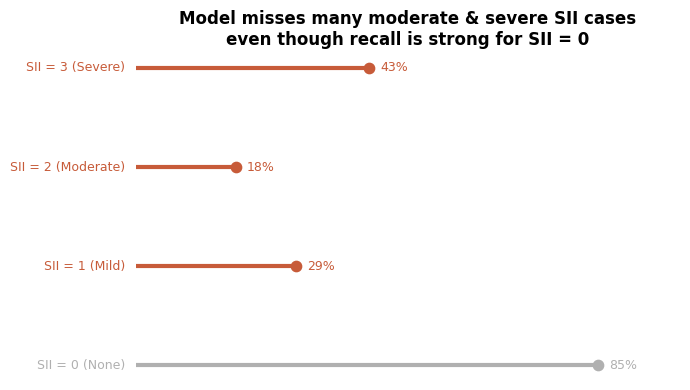

In [71]:
fig, ax = plt.subplots(figsize=(7, 4))

# ===== PALETTE SETUP (Problem section) =====
neutral_grey   = "#B0B0B0"  # context
accent_problem = "#C75B39"  # burnt orange/red cho các lớp recall kém

y_pos = np.arange(len(classes))

# vẽ line cho từng class
for idx, (r, y) in enumerate(zip(recall, y_pos)):
    # SII=0 (idx==0) tốt => dùng xám làm baseline
    color = neutral_grey if idx == 0 else accent_problem
    ax.hlines(y=y, xmin=0, xmax=r, color=color, linewidth=3)
    ax.scatter(r, y, color=color, s=55, zorder=3)

# Ẩn trục & khung, giữ nền trắng
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.set_facecolor("white")

ax.set_xlim(0, 1.0)

# ACTION TITLE – nhấn vấn đề, không chỉ mô tả
ax.set_title(
    "Model misses many moderate & severe SII cases\n"
    "even though recall is strong for SII = 0",
    fontsize=12,
    fontweight='bold',
    color="black"
)

# Nhãn class & % recall – xám cho lớp tốt, cam/đỏ cho lớp vấn đề
for idx, (r, y, cls) in enumerate(zip(recall, y_pos, classes)):
    text_color = neutral_grey if idx == 0 else accent_problem

    # Tên lớp bên trái
    ax.text(-0.02, y, cls,
            ha='right', va='center',
            fontsize=9, color=text_color)

    # % recall bên phải điểm
    ax.text(r + 0.02, y, f'{r:.0%}',
            ha='left', va='center',
            fontsize=9, color=text_color)

plt.tight_layout()
plt.show()


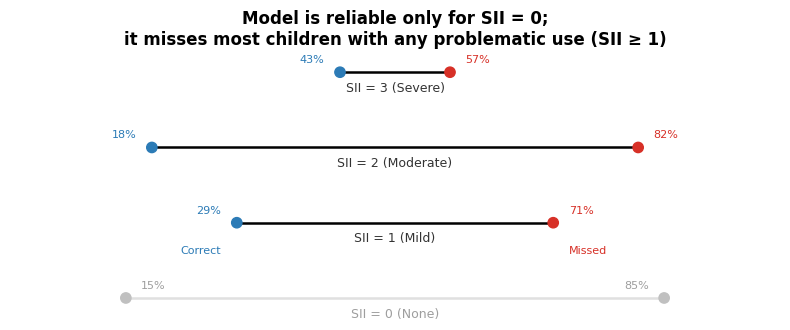

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Recompute rates
labels = [0, 1, 2, 3]
cm = confusion_matrix(y_test, y_pred, labels=labels)
tp = np.diag(cm)
total_true = cm.sum(axis=1)

correct_rate_arr = tp / total_true
miss_rate_arr    = 1 - correct_rate_arr

classes = ['SII = 0 (None)',
           'SII = 1 (Mild)',
           'SII = 2 (Moderate)',
           'SII = 3 (Severe)']
y_pos = np.arange(len(classes))

# palette
grey_line   = '#E0E0E0'
grey_point  = '#C0C0C0'
grey_text   = '#9E9E9E'

correct_hi  = '#2C7BB6'   # blue for Correct
missed_hi   = '#D73027'   # red for Missed

fig, ax = plt.subplots(figsize=(8, 4))

# ----- THÂN DUMBBELL -----
for i in range(len(classes)):
    # SII = 0: line xám; SII >= 1: line đen
    line_color = grey_line if i == 0 else 'black'
    ax.plot([correct_rate_arr[i], miss_rate_arr[i]],
            [y_pos[i], y_pos[i]],
            color=line_color, linewidth=1.8, zorder=1)

# điểm correct/missed
correct_colors = [grey_point] + [correct_hi]*3
missed_colors  = [grey_point] + [missed_hi]*3

ax.scatter(correct_rate_arr, y_pos,
           color=correct_colors, s=55, zorder=2)
ax.scatter(miss_rate_arr,   y_pos,
           color=missed_colors,  s=55, zorder=2)

# bỏ trục
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.set_xlim(0, 1.0)

ax.set_title(
    'Model is reliable only for SII = 0;\n'
    'it misses most children with any problematic use (SII ≥ 1)',
    fontsize=12, fontweight='bold', pad=12
)

# ----- NHÃN TỪNG DÒNG -----
for idx, (y, cls, cr, mr) in enumerate(zip(y_pos, classes,
                                           correct_rate_arr, miss_rate_arr)):
    cls_color   = grey_text if idx == 0 else '#333333'
    correct_col = grey_text if idx == 0 else correct_hi
    missed_col  = grey_text if idx == 0 else missed_hi

    ax.text(0.5, y - 0.12, cls,
            ha='center', va='top', fontsize=9, color=cls_color)

    ax.text(cr - 0.02, y + 0.10, f'{cr:.0%}',
            ha='right', va='bottom', fontsize=8, color=correct_col)

    ax.text(mr + 0.02, y + 0.10, f'{mr:.0%}',
            ha='left', va='bottom', fontsize=8, color=missed_col)

# nhãn Correct / Missed một lần ở dòng mild (SII=1)
y_ref = y_pos[1] - 0.30
ax.text(correct_rate_arr[1] - 0.02, y_ref, 'Correct',
        ha='right', va='top', fontsize=8, color=correct_hi)
ax.text(miss_rate_arr[1]   + 0.02, y_ref, 'Missed',
        ha='left',  va='top', fontsize=8, color=missed_hi)

plt.tight_layout(rect=[0, 0.05, 1, 0.90])
plt.show()


In [78]:
# Paste this into a notebook code cell and run
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, confusion_matrix

sns.set(style="whitegrid")

def per_class_metrics(y_true, y_pred, labels=None):
    """Return recall and FN rate per class and counts."""
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
        labels = np.sort(labels)
    recalls = {}
    fn_rates = {}
    support = {}
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    tp = np.diag(cm)
    support_arr = cm.sum(axis=1)
    for i, lab in enumerate(labels):
        support[i] = int(support_arr[i])
        recall = tp[i] / support_arr[i] if support_arr[i] > 0 else 0.0
        fn_rate = 1.0 - recall
        recalls[i] = recall
        fn_rates[i] = fn_rate
    return labels, recalls, fn_rates, support

def plot_recall_per_class(labels, recalls, title=None, highlight_from=1, colors=None, figsize=(8,4)):
    """Bar + lollipop style recall per class. SII=0 gray, others highlighted."""
    labs = [str(int(l)) for l in labels]
    vals = [recalls[int(l)] for l in labels]
    x = np.arange(len(labs))
    if colors is None:
        colors = []
        for i in range(len(labs)):
            if i == 0:
                colors.append("#BDBDBD")  # gray for SII=0
            else:
                colors.append("#0288D1")  # highlight color
    plt.figure(figsize=figsize)
    plt.hlines(x, 0, vals, colors=colors, linewidth=6, alpha=0.9)
    plt.scatter(vals, x, color=colors, s=120, zorder=3)
    plt.xlim(0, 1.0)
    plt.yticks(x, [f"SII={l}" for l in labs])
    plt.xlabel("Recall")
    if title is None:
        title = "Recall per SII class"
    plt.title(title, fontsize=12, fontweight="bold")
    for xi, v in zip(x, vals):
        plt.text(v + 0.02, xi, f"{v:.0%}", va="center")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_correct_vs_missed(y_true, y_pred, labels=None, title=None, figsize=(8,4)):
    """Dumbbell style: correct% vs missed% per class"""
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
        labels = np.sort(labels)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    tp = np.diag(cm).astype(float)
    support = cm.sum(axis=1).astype(float)
    correct_pct = tp / support
    missed_pct = 1 - correct_pct
    labs = [f"SII={int(l)}" for l in labels]
    y = np.arange(len(labs))
    plt.figure(figsize=figsize)
    for i in range(len(labs)):
        plt.plot([correct_pct[i], missed_pct[i]], [y[i], y[i]], color="#BDBDBD", lw=2, zorder=1)
        plt.scatter(correct_pct[i], y[i], color="#2C7BB6", s=90, label="Correct" if i==0 else "", zorder=3)
        plt.scatter(missed_pct[i], y[i], color="#D73027", s=90, label="Missed" if i==0 else "", zorder=3)
    plt.yticks(y, labs)
    plt.xlim(0,1)
    plt.xlabel("Proportion")
    if title is None:
        title = "Correct vs Missed per class"
    plt.title(title, fontsize=12, fontweight="bold")
    # legend
    plt.legend(loc="lower right")
    for i, (c, m) in enumerate(zip(correct_pct, missed_pct)):
        plt.text(c - 0.03, y[i] - 0.12, f"{c:.0%}", ha="center", color="#2C7BB6")
        plt.text(m + 0.03, y[i] - 0.12, f"{m:.0%}", ha="center", color="#D73027")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_risk_group_recall(y_true, y_pred, title=None, figsize=(6,4)):
    """Compute recall for Non-severe (SII 0-1) vs Severe (SII 2-3)"""
    # define groups
    df = pd.DataFrame({"y": y_true, "pred": y_pred})
    df["true_group"] = df["y"].map(lambda v: "Non-severe (0-1)" if v in [0,1] else "Severe (2-3)")
    # for recall we need binary true/pred per group: predict group label and compute recall on group membership
    df["pred_group"] = df["pred"].map(lambda v: "Non-severe (0-1)" if v in [0,1] else "Severe (2-3)")
    groups = ["Non-severe (0-1)", "Severe (2-3)"]
    recalls = []
    for g in groups:
        mask = df["true_group"] == g
        if mask.sum() == 0:
            recalls.append(0.0)
            continue
        y_true_bin = (df.loc[mask, "true_group"] == g).astype(int)  # all ones
        y_pred_bin = (df.loc[mask, "pred_group"] == g).astype(int)
        # recall = TP / (TP + FN) where TP = sum(y_pred_bin==1), FN = sum(y_pred_bin==0)
        recall = (y_pred_bin == 1).sum() / mask.sum()
        recalls.append(recall)
    plt.figure(figsize=figsize)
    colors = ["#BDBDBD", "#F58518"]
    plt.bar(groups, recalls, color=colors)
    plt.ylim(0,1)
    for i, v in enumerate(recalls):
        plt.text(i, v + 0.02, f"{v:.0%}", ha="center")
    if title is None:
        title = "Recall: Non-severe vs Severe"
    plt.title(title, fontsize=12, fontweight="bold")
    plt.ylabel("Recall")
    plt.tight_layout()
    plt.show()

# Utility to plot trend across stages for a chosen metric (e.g., recall SII>=1)
def plot_stage_trend(stage_results, metric="recall_ge1", figsize=(8,4)):
    """
    stage_results: list of tuples (y_true, y_pred, label)
    metric options:
      - 'recall_ge1' : recall across SII >=1 (i.e., combined recall for classes 1..3)
      - 'recall_2_3'  : recall for classes 2..3 (severe)
    """
    labels = []
    values = []
    for y_true, y_pred, label in stage_results:
        labels.append(label)
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        if metric == "recall_ge1":
            mask = y_true >= 1
            if mask.sum() == 0:
                values.append(0.0)
            else:
                y_true_sub = y_true[mask]
                y_pred_sub = y_pred[mask]
                # compute whether predicted >=1
                recall = ((y_pred_sub >= 1).astype(int) == 1).sum() / mask.sum()
                values.append(recall)
        elif metric == "recall_2_3":
            mask = (y_true == 2) | (y_true == 3)
            if mask.sum() == 0:
                values.append(0.0)
            else:
                y_true_sub = y_true[mask]
                y_pred_sub = y_pred[mask]
                recall = ((y_pred_sub >= 2).astype(int) == 1).sum() / mask.sum()
                values.append(recall)
        else:
            raise ValueError("Unknown metric")
    plt.figure(figsize=figsize)
    plt.plot(labels, values, marker='o', linewidth=2, color="#0288D1")
    plt.ylim(0,1)
    for x,yv in zip(labels, values):
        plt.text(x, yv + 0.02, f"{yv:.0%}", ha="center")
    title_map = {
        "recall_ge1": "Recall for SII >= 1 across stages",
        "recall_2_3": "Recall for SII 2-3 (Severe) across stages"
    }
    plt.title(title_map.get(metric, metric), fontsize=12, fontweight="bold")
    plt.ylabel("Recall")
    plt.xlabel("Stage")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# === Example usage ===
# Suppose you have predictions for 4 stages: raw, balanced, cleaned, engineered
# stage_results = [
#     (y_test_raw, y_pred_raw, "Raw"),
#     (y_test_bal, y_pred_bal, "Balanced"),
#     (y_test_clean, y_pred_clean, "Cleaned"),
#     (y_test_feat, y_pred_feat, "Engineered")
# ]
#
# For single-stage explanatory charts (per-stage):
# y_true, y_pred, label = stage_results[0]
# labels_arr, recalls, fn_rates, support = per_class_metrics(y_true, y_pred, labels=np.array([0,1,2,3]))
# plot_recall_per_class(labels_arr, recalls, title="Model is reliable only for SII=0; recall drops sharply for SII≥1.")
# plot_correct_vs_missed(y_true, y_pred, title="Correct vs Missed per SII class")
# plot_risk_group_recall(y_true, y_pred, title="Model underperforms on high-risk children (SII 2–3).")
#
# To show stage trends:
# plot_stage_trend(stage_results, metric='recall_ge1')
# plot_stage_trend(stage_results, metric='recall_2_3')

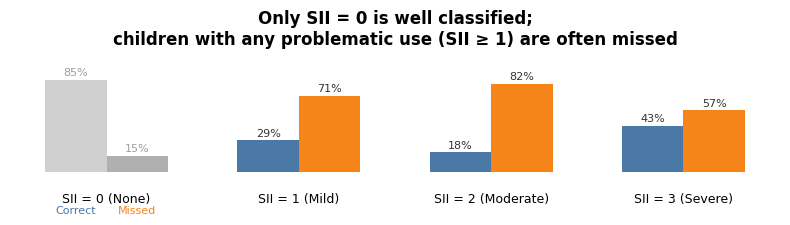

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# correct_rate_arr, miss_rate_arr, classes
x = np.arange(len(classes))

# màu
grey_correct = '#D0D0D0'
grey_missed  = '#B0B0B0'
grey_text    = '#9E9E9E'

soft_blue    = '#4C78A8'   # Correct (problematic classes)
soft_orange  = '#F58518'   # Missed  (problematic classes)

fig, ax = plt.subplots(figsize=(8, 3.5))

width = 0.32
bars_correct = []
bars_missed  = []

for i, xi in enumerate(x):
    if i == 0:
        # SII = 0: tất cả xám
        c_col = grey_correct
        m_col = grey_missed
    else:
        # SII >= 1: dùng màu nhấn mềm
        c_col = soft_blue
        m_col = soft_orange

    bars_correct.append(
        ax.bar(xi - width/2, correct_rate_arr[i],
               width=width, color=c_col)
    )
    bars_missed.append(
        ax.bar(xi + width/2, miss_rate_arr[i],
               width=width, color=m_col)
    )

# bỏ trục & tick
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.set_ylim(0, 1.05)

# TITLE = insight
ax.set_title(
    'Only SII = 0 is well classified;\n'
    'children with any problematic use (SII ≥ 1) are often missed',
    fontsize=12, fontweight='bold', pad=10
)

# tên lớp
for xi, cls in zip(x, classes):
    ax.text(xi, -0.18, cls,
            ha='center', va='top', fontsize=9)

# nhãn %
for xi, c, m, i in zip(x, correct_rate_arr, miss_rate_arr, range(len(classes))):
    txt_color = grey_text if i == 0 else '#333333'
    ax.text(xi - width/2, c + 0.02, f'{c:.0%}',
            ha='center', va='bottom', fontsize=8, color=txt_color)
    ax.text(xi + width/2, m + 0.02, f'{m:.0%}',
            ha='center', va='bottom', fontsize=8, color=txt_color)

# Direct label “Correct / Missed” dưới cặp cột đầu tiên (thay legend)
y_label_line = -0.30
ax.text(x[0] - width/2, y_label_line, 'Correct',
        ha='center', va='top', fontsize=8, color=soft_blue)
ax.text(x[0] + width/2, y_label_line, 'Missed',
        ha='center', va='top', fontsize=8, color=soft_orange)

plt.tight_layout(rect=[0, 0.10, 1, 0.90])

plt.show()


📊 ROC CURVE & PRECISION-RECALL CURVE ANALYSIS

📊 ROC-AUC & AVERAGE PRECISION SUMMARY
           Class ROC-AUC Avg Precision  Support
    SII=0 (None)  0.7644        0.8221      319
    SII=1 (Mild)  0.6483        0.3717      146
SII=2 (Moderate)  0.7345        0.2796       76
  SII=3 (Severe)  0.8553        0.4820        7

📊 Overall Metrics:
  - Micro-average ROC-AUC:        0.8584
  - Micro-average Avg Precision:  0.6849
  - Macro-average ROC-AUC:        0.7506
  - Macro-average Avg Precision:  0.4888

💡 INTERPRETATION

📊 ROC-AUC Score Interpretation:
   • 1.0 = Perfect classifier
   • 0.9-1.0 = Excellent
   • 0.8-0.9 = Good
   • 0.7-0.8 = Fair
   • 0.6-0.7 = Poor
   • 0.5-0.6 = Fail (barely better than random)
   • 0.5 = Random guessing

📊 Average Precision (AP) Interpretation:
   • AP is the area under Precision-Recall curve
   • More informative than ROC-AUC for imbalanced datasets
   • Higher is better (max = 1.0)

🔍 What We See:
   • SII=0 (majority class): High AUC = 0.764
   •

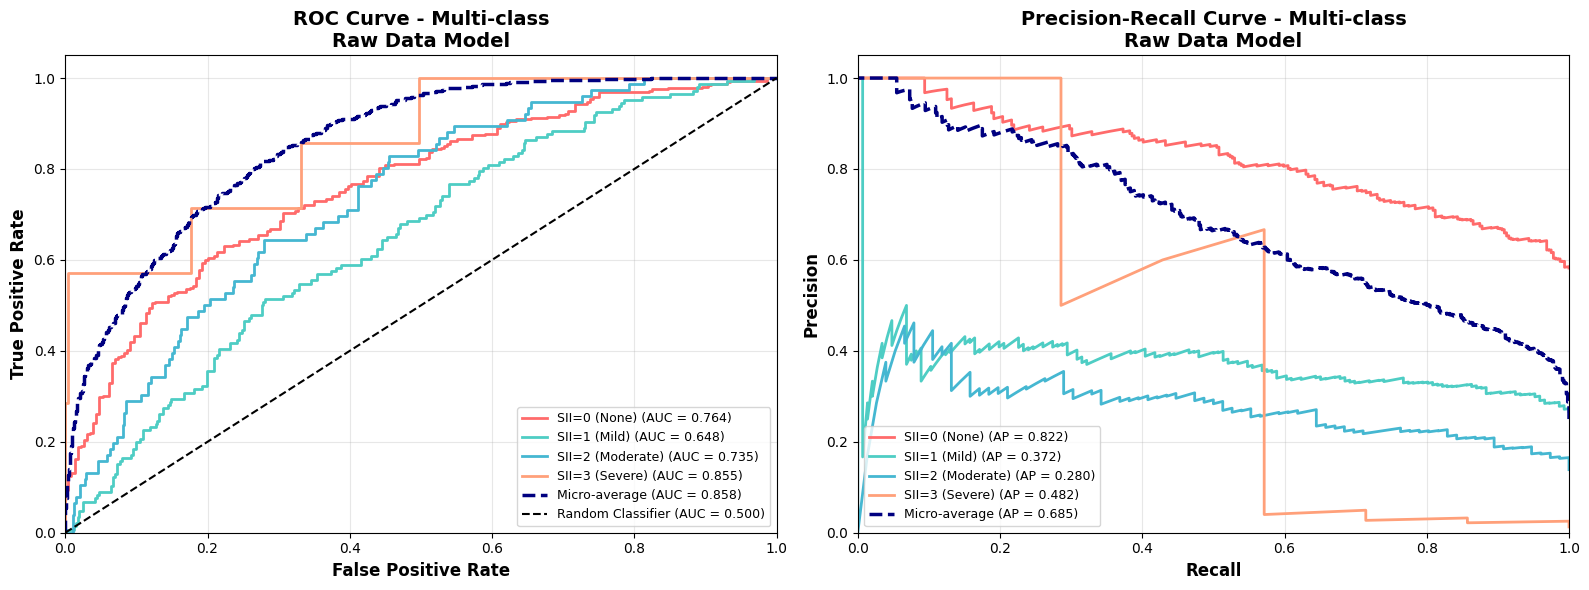

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# ========================================
# ROC CURVE & PRECISION-RECALL CURVE
# ========================================

print("="*70)
print("📊 ROC CURVE & PRECISION-RECALL CURVE ANALYSIS")
print("="*70)

# Get probability predictions instead of hard predictions
y_pred_proba = xgb_model.predict_proba(X_test)

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# ========================================
# COMPUTE ROC CURVE AND AUC FOR EACH CLASS
# ========================================
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ========================================
# COMPUTE PRECISION-RECALL CURVE FOR EACH CLASS
# ========================================
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])

# Compute micro-average precision-recall curve
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_pred_proba.ravel()
)
avg_precision["micro"] = average_precision_score(y_test_bin, y_pred_proba, average="micro")

# ========================================
# PLOT ROC CURVES
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors
colors = cycle(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
class_names = ['SII=0 (None)', 'SII=1 (Mild)', 'SII=2 (Moderate)', 'SII=3 (Severe)']

# ========== Plot 1: ROC Curve ==========
ax = axes[0]

# Plot ROC curve for each class
for i, color, name in zip(range(n_classes), colors, class_names):
    ax.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'{name} (AUC = {roc_auc[i]:.3f})')

# Plot micro-average ROC curve
ax.plot(fpr["micro"], tpr["micro"],
        label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
        color='navy', linestyle='--', linewidth=2.5)

# Plot diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve - Multi-class\nRaw Data Model', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=9)
ax.grid(alpha=0.3)

# ========== Plot 2: Precision-Recall Curve ==========
ax = axes[1]

# Plot Precision-Recall curve for each class
colors = cycle(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
for i, color, name in zip(range(n_classes), colors, class_names):
    ax.plot(recall[i], precision[i], color=color, lw=2,
            label=f'{name} (AP = {avg_precision[i]:.3f})')

# Plot micro-average Precision-Recall curve
ax.plot(recall["micro"], precision["micro"],
        label=f'Micro-average (AP = {avg_precision["micro"]:.3f})',
        color='navy', linestyle='--', linewidth=2.5)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve - Multi-class\nRaw Data Model', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()

# ========================================
# PRINT SUMMARY STATISTICS
# ========================================
print("\n" + "="*70)
print("📊 ROC-AUC & AVERAGE PRECISION SUMMARY")
print("="*70)

summary_data = []
for i, name in enumerate(class_names):
    summary_data.append({
        'Class': name,
        'ROC-AUC': f"{roc_auc[i]:.4f}",
        'Avg Precision': f"{avg_precision[i]:.4f}",
        'Support': int(y_test_bin[:, i].sum())
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n📊 Overall Metrics:")
print(f"  - Micro-average ROC-AUC:        {roc_auc['micro']:.4f}")
print(f"  - Micro-average Avg Precision:  {avg_precision['micro']:.4f}")

# Calculate macro-average
macro_roc_auc = np.mean([roc_auc[i] for i in range(n_classes)])
macro_avg_precision = np.mean([avg_precision[i] for i in range(n_classes)])
print(f"  - Macro-average ROC-AUC:        {macro_roc_auc:.4f}")
print(f"  - Macro-average Avg Precision:  {macro_avg_precision:.4f}")

# ========================================
# INTERPRETATION
# ========================================
print("\n" + "="*70)
print("💡 INTERPRETATION")
print("="*70)

print(f"""
📊 ROC-AUC Score Interpretation:
   • 1.0 = Perfect classifier
   • 0.9-1.0 = Excellent
   • 0.8-0.9 = Good
   • 0.7-0.8 = Fair
   • 0.6-0.7 = Poor
   • 0.5-0.6 = Fail (barely better than random)
   • 0.5 = Random guessing

📊 Average Precision (AP) Interpretation:
   • AP is the area under Precision-Recall curve
   • More informative than ROC-AUC for imbalanced datasets
   • Higher is better (max = 1.0)

🔍 What We See:
   • SII=0 (majority class): High AUC = {roc_auc[0]:.3f}
   • SII=1,2,3 (minority classes): Lower AUC
   • This confirms the model's bias toward the majority class
   
⚠️  Problem:
   The model is good at distinguishing SII=0 from others,
   but struggles with SII=1,2,3 (the cases that need help!)
""")

print("="*70)

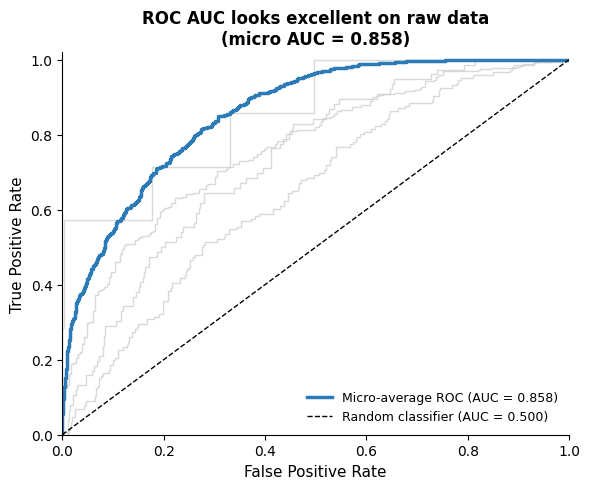

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize + predict_proba như bạn đã làm
y_pred_proba = xgb_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# ROC per class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(),
                                          y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ------- PLOT EXPLANATORY ROC -------
fig, ax = plt.subplots(figsize=(6, 5))

# 1) class-wise ROC as light grey background
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i],
            color='#D0D0D0', lw=1, alpha=0.8)

# 2) micro-average ROC as main character
ax.plot(
    fpr["micro"], tpr["micro"],
    color='#2C7BB6', lw=2.5,
    label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})'
)

# 3) random baseline
ax.plot([0, 1], [0, 1],
        'k--', lw=1, label='Random classifier (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.02])
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)

ax.set_title(
    'ROC AUC looks excellent on raw data\n'
    f'(micro AUC = {roc_auc["micro"]:.3f})',
    fontsize=12, fontweight='bold'
)

# minimal styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

ax.legend(loc='lower right', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()


NameError: name 'class_labels' is not defined

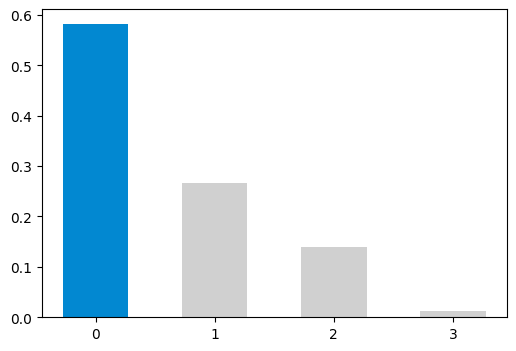

In [76]:
supports = y_test_bin.sum(axis=0).astype(int)   # n per class
fractions = supports / supports.sum()

x = np.arange(n_classes)

fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#0288D1', '#D0D0D0', '#D0D0D0', '#D0D0D0']  # SII=0 highlight
bars = ax.bar(x, fractions, color=colors, width=0.55)

ax.set_xticks(x)
ax.set_xticklabels(class_labels, fontsize=9)
ax.set_ylim(0, 1.0)
ax.set_ylabel('Share of test set', fontsize=11)

ax.set_title(
    'Class imbalance: SII = 0 dominates the test set',
    fontsize=12, fontweight='bold'
)

for xi, frac, n in zip(x, fractions, supports):
    ax.text(xi, frac + 0.02, f'{frac:.0%}\n(n={n})',
            ha='center', va='bottom', fontsize=8, color='#01579B')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()


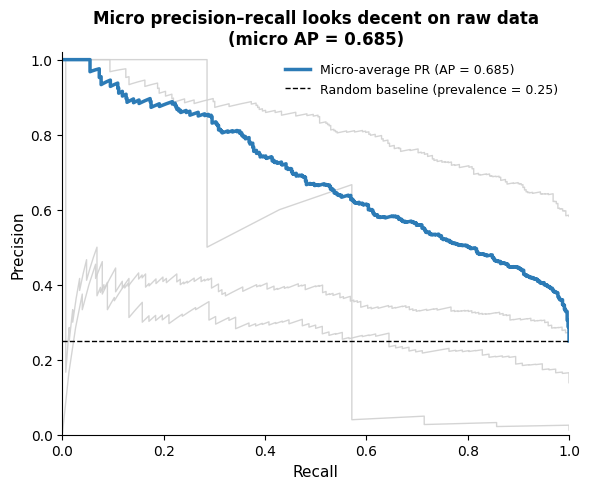

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# precision, recall, avg_precision đã có từ đoạn code trước
# precision[i], recall[i] cho từng lớp
# precision["micro"], recall["micro"] cho micro-average

fig, ax = plt.subplots(figsize=(6, 5))

# 1) class-wise PR làm nền xám
for i in range(n_classes):
    ax.plot(recall[i], precision[i],
            color='#D0D0D0', lw=1, alpha=0.9)

# 2) micro-average PR là nhân vật chính
ax.plot(
    recall["micro"], precision["micro"],
    color='#2C7BB6', lw=2.5,
    label=f'Micro-average PR (AP = {avg_precision["micro"]:.3f})'
)

# 3) baseline cho random classifier = tỷ lệ positive chung
pos_fraction = y_test_bin.mean()  # ~ prevalence
ax.hlines(pos_fraction, 0, 1,
          colors='black', linestyles='--', linewidth=1,
          label=f'Random baseline (prevalence = {pos_fraction:.2f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.02])
ax.set_xlabel('Recall', fontsize=11)
ax.set_ylabel('Precision', fontsize=11)

ax.set_title(
    'Micro precision–recall looks decent on raw data\n'
    f'(micro AP = {avg_precision["micro"]:.3f})',
    fontsize=12, fontweight='bold'
)

# tối giản
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

ax.legend(loc='upper right', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()


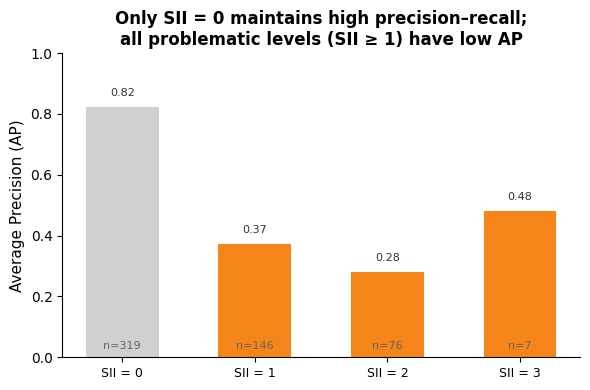

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy AP từng lớp
ap_values = [avg_precision[i] for i in range(n_classes)]
class_labels = ['SII = 0', 'SII = 1', 'SII = 2', 'SII = 3']
supports = y_test_bin.sum(axis=0).astype(int)

x = np.arange(n_classes)

fig, ax = plt.subplots(figsize=(6, 4))

# SII=0 xám (background), SII>=1 tô màu nhấn (vì là các lớp problematic)
colors = ['#D0D0D0', '#F58518', '#F58518', '#F58518']

bars = ax.bar(x, ap_values, color=colors, width=0.55)

ax.set_xticks(x)
ax.set_xticklabels(class_labels, fontsize=9)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Average Precision (AP)', fontsize=11)

ax.set_title(
    'Only SII = 0 maintains high precision–recall;\n'
    'all problematic levels (SII ≥ 1) have low AP',
    fontsize=12, fontweight='bold'
)

# Ghi AP và n cho từng lớp
for xi, ap, n in zip(x, ap_values, supports):
    ax.text(xi, ap + 0.03, f'{ap:.2f}',
            ha='center', va='bottom', fontsize=8, color='#333333')
    ax.text(xi, 0.02, f'n={n}',
            ha='center', va='bottom', fontsize=8, color='#666666')

# tối giản
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()


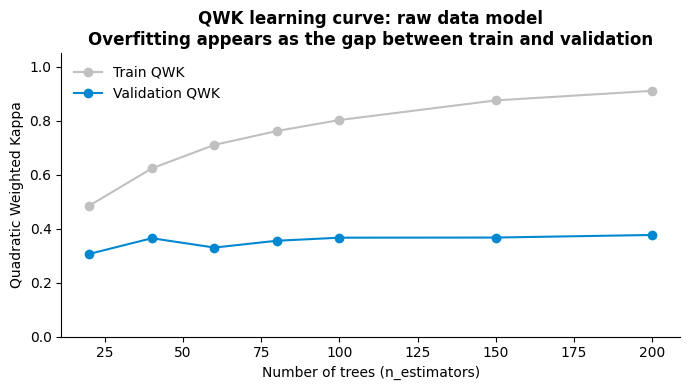

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import cohen_kappa_score
import numpy as np
import matplotlib.pyplot as plt

# 1) Chọn các giá trị n_estimators để quét
est_list = [20, 40, 60, 80, 100, 150, 200]

train_qwk = []
valid_qwk = []

for n in est_list:
    model = XGBClassifier(
        n_estimators=n,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=4,
        n_jobs=-1,
        eval_metric='mlogloss'   # metric nội bộ, QWK ta tự tính
    )
    
    model.fit(X_train, y_train)
    
    # 2) Dự đoán & tính QWK cho train / validation (dùng X_test/y_test)
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    
    train_qwk.append(cohen_kappa_score(y_train, y_train_pred, weights='quadratic'))
    valid_qwk.append(cohen_kappa_score(y_test,  y_test_pred,  weights='quadratic'))

# 3) Vẽ learning curve
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(est_list, train_qwk, marker='o', color='#C0C0C0', label='Train QWK')
ax.plot(est_list, valid_qwk, marker='o', color='#0288D1', label='Validation QWK')

ax.set_xlabel('Number of trees (n_estimators)')
ax.set_ylabel('Quadratic Weighted Kappa')
ax.set_ylim(0, 1.05)

ax.set_title(
    'QWK learning curve: raw data model\n'
    'Overfitting appears as the gap between train and validation',
    fontsize=12, fontweight='bold'
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*70)
print("🔍 SHAP ANALYSIS - XGBoost Model")
print("="*70)

try:
    # ========================================
    # 1. CHUẨN BỊ DỮ LIỆU ĐẦU VÀO CHO SHAP
    # ========================================
    sample_size = min(500, len(X_test))  # tránh quá nặng
    # Chỉ dùng đúng các feature đã train model
    X_test_sample = X_test[X_train.columns].sample(
        n=sample_size, random_state=42
    ).copy()

    # Ép toàn bộ cột về numeric, lỗi chuyển thành NaN
    for col in X_test_sample.columns:
        X_test_sample[col] = pd.to_numeric(X_test_sample[col], errors='coerce')

    print("✓ X_test_sample prepared.")
    print("  - Shape:", X_test_sample.shape)

    # ========================================
    # 2. TẠO SHAP EXPLAINER
    # ========================================
    explainer = shap.TreeExplainer(xgb_model)
    print("✓ SHAP explainer created.")

    # ========================================
    # 3. TÍNH SHAP VALUES
    # ========================================
    print("⏳ Computing SHAP values...")
    shap_raw = explainer.shap_values(X_test_sample)
    arr = np.array(shap_raw)

    # Chuẩn hoá shap_values về dạng list: [n_class] mỗi phần tử (n_samples, n_features)
    if isinstance(shap_raw, list):
        # Kiểu cũ: list per class
        shap_list = shap_raw
    else:
        # Kiểu mới: numpy array
        if arr.ndim == 2:
            # Regression / binary: (n_samples, n_features)
            shap_list = [arr]
        elif arr.ndim == 3:
            # (n_samples, n_features, n_classes) hoặc (n_samples, n_classes, n_features)
            if arr.shape[1] == X_test_sample.shape[1]:
                # (n_samples, n_features, n_classes)
                shap_list = [arr[:, :, i] for i in range(arr.shape[2])]
            else:
                # (n_samples, n_classes, n_features)
                shap_list = [arr[:, i, :] for i in range(arr.shape[1])]
        else:
            raise ValueError(f"Unexpected SHAP values shape: {arr.shape}")

    n_classes = len(shap_list)

    # Đặt tên class cho đẹp (chỉ dùng đủ số class thực tế)
    if n_classes == 1:
        class_names = ["Output"]
    else:
        class_names_full = [
            'SII=0 (None)',
            'SII=1 (Mild)',
            'SII=2 (Moderate)',
            'SII=3 (Severe)'
        ]
        class_names = class_names_full[:n_classes]

    print(f"✓ SHAP computed.")
    print(f"  - n_classes: {n_classes}")
    print(f"  - shap shape per class: {shap_list[0].shape}")

    # ========================================
    # 4. VẼ SHAP SUMMARY PLOT (BEESWARM)
    # ========================================
    print("\n📊 Generating SHAP summary plots (beeswarm)...")

    for i in range(n_classes):
        shap.summary_plot(
            shap_list[i],
            X_test_sample,
            max_display=15,
            show=False
        )
        plt.title(
            f"SHAP Summary Plot – {class_names[i]}",
            fontsize=13,
            fontweight='bold'
        )
        plt.tight_layout()
        plt.show()

    # ========================================
    # 5. TOP FEATURES PER CLASS (mean |SHAP|)
    # ========================================
    print("\n📋 Top 10 Features per Class (by mean |SHAP|):")

    for i in range(n_classes):
        mean_abs_shap = np.abs(shap_list[i]).mean(axis=0)
        top_indices = np.argsort(mean_abs_shap)[-10:][::-1]
        top_feat_names = X_test_sample.columns[top_indices]
        top_feat_values = mean_abs_shap[top_indices]

        print(f"\n🎯 {class_names[i]}:")
        for feat, val in zip(top_feat_names, top_feat_values):
            print(f"   • {feat:40s}: {val:.4f}")

except Exception as e:
    print(f"\n⚠️  Error computing SHAP values: {e}")


🔍 SHAP ANALYSIS - XGBoost Model
✓ X_test_sample prepared.
  - Shape: (500, 139)

⚠️  Error computing SHAP values: could not convert string to float: '[5.82724E-1,2.6691043E-1,1.380256E-1,1.2340036E-2]'


In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*70)
print("🔍 SHAP ANALYSIS - XGBoost Model (KernelExplainer with wrapper)")
print("="*70)

try:
    # =====================================================
    # 1. CHUẨN HÓA DỮ LIỆU: CHỈ DÙNG FEATURE ĐÃ TRAIN & ÉP NUMERIC
    # =====================================================
    # Chỉ lấy đúng các cột mà model đã train
    X_test_numeric = X_test[X_train.columns].copy()

    # Ép toàn bộ DataFrame sang numeric, sai -> NaN
    X_test_numeric = X_test_numeric.apply(
        lambda col: pd.to_numeric(col, errors='coerce')
    )

    feature_names = X_test_numeric.columns.tolist()

    print("✓ X_test_numeric prepared.")
    print("  - Shape:", X_test_numeric.shape)

    # Background data cho KernelExplainer (dạng numpy)
    background_size = min(100, len(X_test_numeric))
    background_df = X_test_numeric.sample(n=background_size, random_state=42)
    background = background_df.values

    # Data để vẽ SHAP (dạng numpy)
    sample_size = min(200, len(X_test_numeric))
    X_shap_df = X_test_numeric.sample(n=sample_size, random_state=123)
    X_shap = X_shap_df.values

    # =====================================================
    # 2. TẠO HÀM WRAPPER CHO PREDICT_PROBA
    # =====================================================
    # Quan trọng: dùng hàm wrapper, không đưa trực tiếp model vào KernelExplainer
    def model_predict_proba(X):
        # X sẽ là numpy array
        return xgb_model.predict_proba(X)

    # =====================================================
    # 3. TẠO SHAP EXPLAINER (KERNEL) – DÙNG WRAPPER + NUMPY ARRAY
    # =====================================================
    print("⏳ Creating KernelExplainer...")
    explainer = shap.KernelExplainer(
        model_predict_proba,   # dùng hàm wrapper, không phải model trực tiếp
        background             # numpy array
    )
    print("✓ KernelExplainer created.")

    # =====================================================
    # 4. TÍNH SHAP VALUES
    # =====================================================
    print("⏳ Computing SHAP values on sample data...")
    shap_raw = explainer.shap_values(X_shap)

    # KernelExplainer với multi-class: shap_raw là list, mỗi phần tử (n_samples, n_features)
    if isinstance(shap_raw, list):
        shap_list = shap_raw
    else:
        arr = np.array(shap_raw)
        if arr.ndim == 2:
            shap_list = [arr]
        elif arr.ndim == 3:
            # (n_samples, n_classes, n_features)
            shap_list = [arr[:, i, :] for i in range(arr.shape[1])]
        else:
            raise ValueError(f"Unexpected SHAP array shape: {arr.shape}")

    n_classes = len(shap_list)

    # Đặt tên class: chỉnh nếu label mapping khác
    if n_classes == 1:
        class_names = ["Output"]
    else:
        class_names_full = [
            'SII=0 (None)',
            'SII=1 (Mild)',
            'SII=2 (Moderate)',
            'SII=3 (Severe)'
        ]
        class_names = class_names_full[:n_classes]

    print(f"✓ SHAP computed.")
    print(f"  - n_classes: {n_classes}")
    print(f"  - shap shape per class: {shap_list[0].shape}")

    # =====================================================
    # 5. VẼ SHAP SUMMARY PLOT (BEESWARM)
    # =====================================================
    print("\n📊 Generating SHAP summary plots (beeswarm)...")

    for i in range(n_classes):
        shap.summary_plot(
            shap_list[i],
            X_shap,                      # numpy array
            feature_names=feature_names, # tên cột
            max_display=15,
            show=False
        )
        plt.title(
            f"SHAP Summary Plot – {class_names[i]}",
            fontsize=13,
            fontweight='bold'
        )
        plt.tight_layout()
        plt.show()

    # =====================================================
    # 6. TOP FEATURES PER CLASS (mean |SHAP|)
    # =====================================================
    print("\n📋 Top 10 Features per Class (by mean |SHAP|):")

    feature_names_arr = np.array(feature_names)

    for i in range(n_classes):
        mean_abs_shap = np.abs(shap_list[i]).mean(axis=0)
        top_indices = np.argsort(mean_abs_shap)[-10:][::-1]
        top_feat_names = feature_names_arr[top_indices]
        top_feat_values = mean_abs_shap[top_indices]

        print(f"\n🎯 {class_names[i]}:")
        for feat, val in zip(top_feat_names, top_feat_values):
            print(f"   • {feat:40s}: {val:.4f}")

except Exception as e:
    print(f"\n⚠️  Error computing SHAP values with KernelExplainer: {e}")


🔍 SHAP ANALYSIS - XGBoost Model (KernelExplainer with wrapper)
✓ X_test_numeric prepared.
  - Shape: (548, 139)
⏳ Creating KernelExplainer...
✓ KernelExplainer created.
⏳ Computing SHAP values on sample data...


100%|██████████| 200/200 [03:04<00:00,  1.09it/s]

✓ SHAP computed.
  - n_classes: 139
  - shap shape per class: (200, 4)

📊 Generating SHAP summary plots (beeswarm)...

⚠️  Error computing SHAP values with KernelExplainer: The shape of the shap_values matrix does not match the shape of the provided data matrix.



📊 Global feature importance (mean |SHAP|, Top 10 per class)...


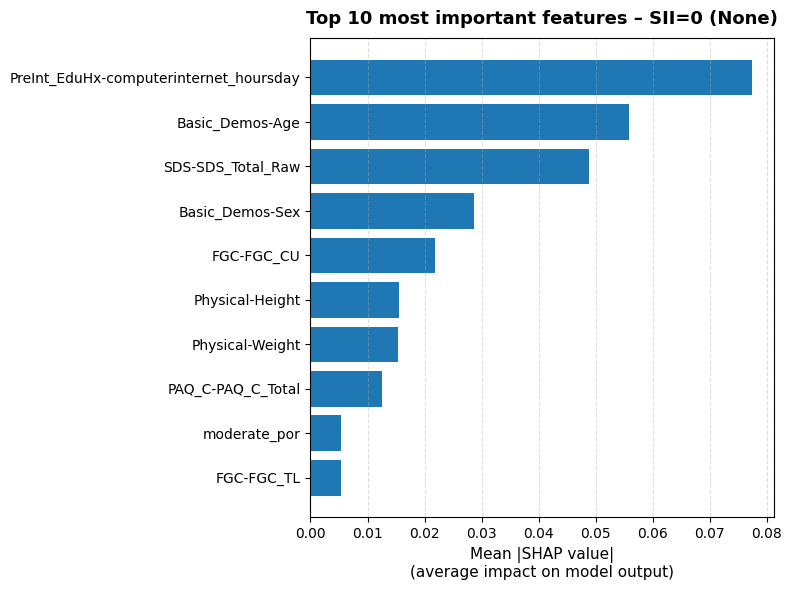

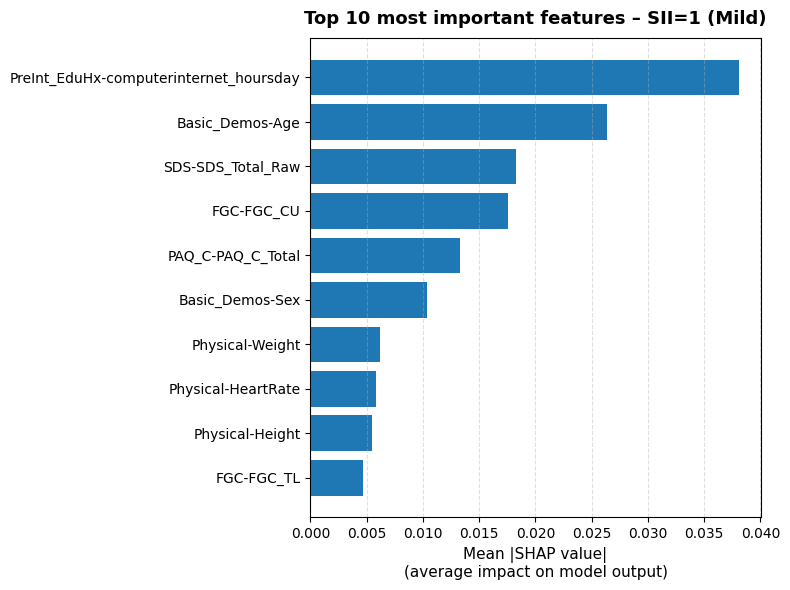

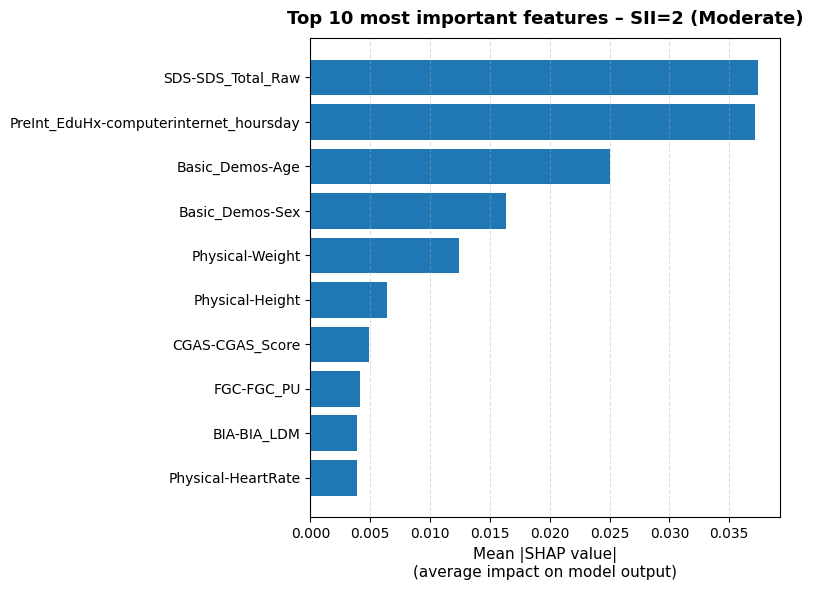

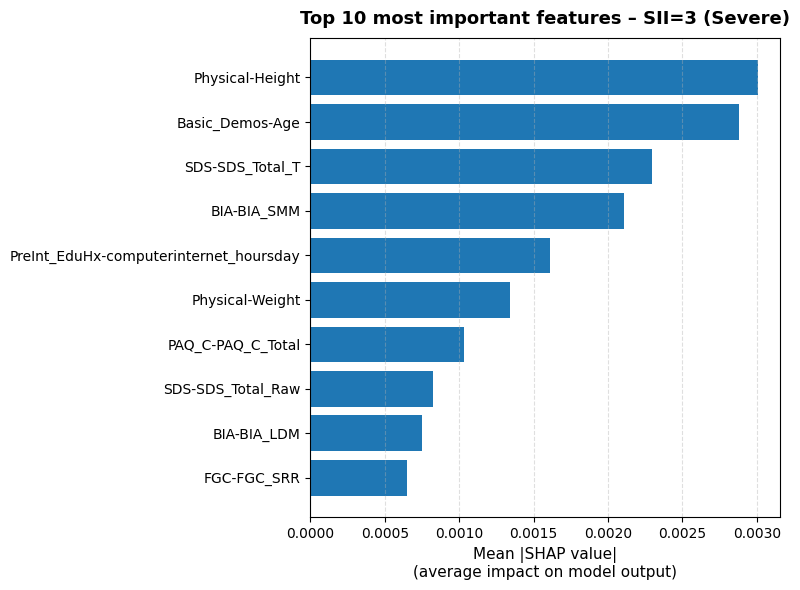


📊 SHAP summary (beeswarm) for Top 10 features per class...


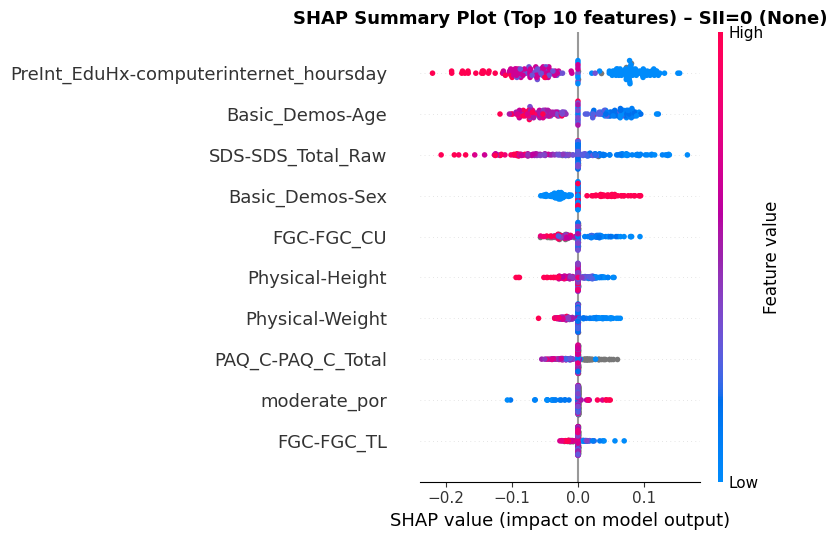

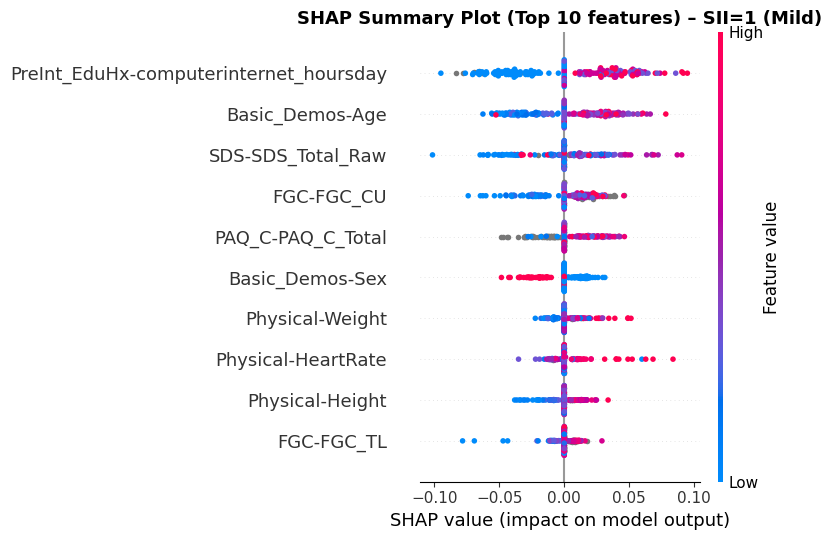

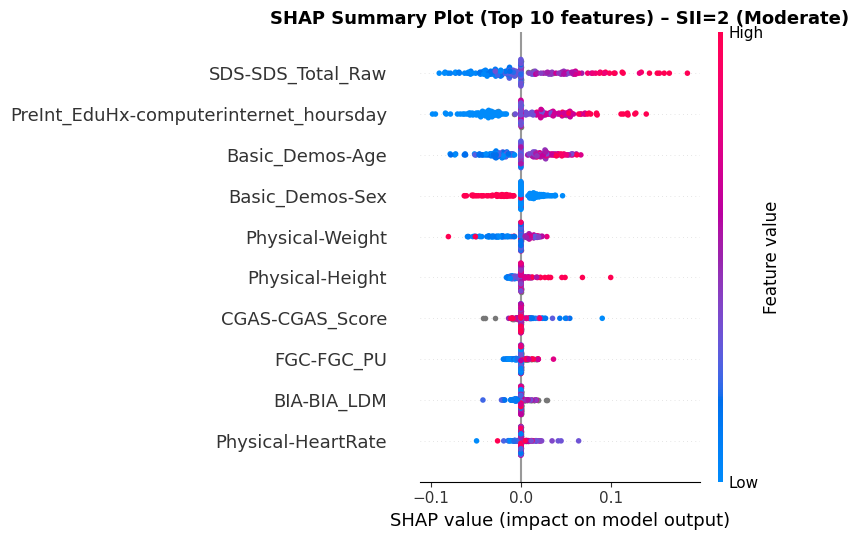

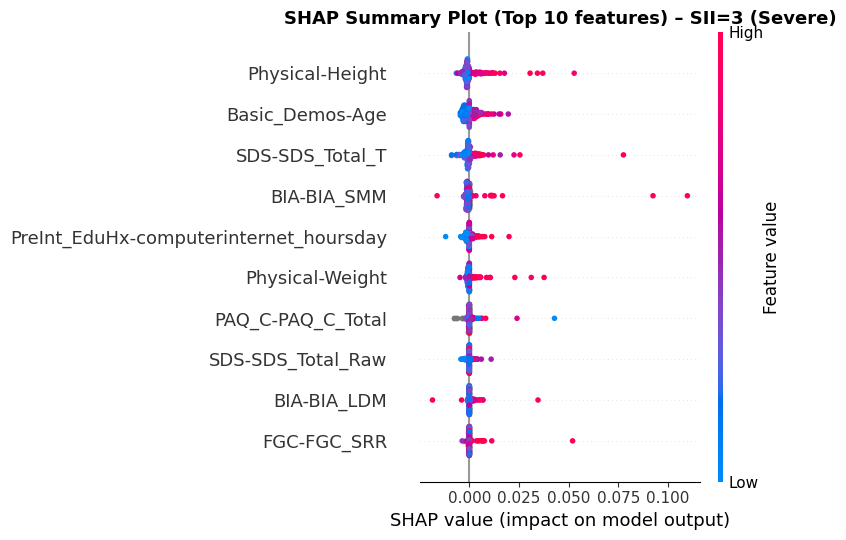


📋 Top 10 Features per Class (by mean |SHAP|):

🎯 SII=0 (None):
   • PreInt_EduHx-computerinternet_hoursday  : 0.0773
   • Basic_Demos-Age                         : 0.0558
   • SDS-SDS_Total_Raw                       : 0.0488
   • Basic_Demos-Sex                         : 0.0287
   • FGC-FGC_CU                              : 0.0219
   • Physical-Height                         : 0.0155
   • Physical-Weight                         : 0.0153
   • PAQ_C-PAQ_C_Total                       : 0.0125
   • moderate_por                            : 0.0054
   • FGC-FGC_TL                              : 0.0054

🎯 SII=1 (Mild):
   • PreInt_EduHx-computerinternet_hoursday  : 0.0381
   • Basic_Demos-Age                         : 0.0263
   • SDS-SDS_Total_Raw                       : 0.0182
   • FGC-FGC_CU                              : 0.0176
   • PAQ_C-PAQ_C_Total                       : 0.0133
   • Basic_Demos-Sex                         : 0.0103
   • Physical-Weight                         : 0.0062
 

In [ ]:
# =====================================================
# 5. GLOBAL BAR PLOT – EXPLANATORY VERSION
# =====================================================
print("\n📊 Global feature importance (mean |SHAP|, Top 10 per class)...")

feature_names_arr = np.array(feature_names)

for i in range(n_classes):
    shap_values_class = shap_list[i]              # (n_samples, n_features)
    mean_abs_shap = np.abs(shap_values_class).mean(axis=0)  # (n_features,)

    # Lấy Top 10 feature
    top_indices = np.argsort(mean_abs_shap)[-10:]
    top_scores = mean_abs_shap[top_indices]
    top_feats = feature_names_arr[top_indices]

    # Sort lại theo score tăng dần để vẽ barh đẹp
    order = np.argsort(top_scores)
    top_scores = top_scores[order]
    top_feats = top_feats[order]

    plt.figure(figsize=(8, 6))
    plt.barh(top_feats, top_scores)
    plt.xlabel("Mean |SHAP value|\n(average impact on model output)", fontsize=11)
    plt.title(f"Top 10 most important features – {class_names[i]}",
              fontsize=13, fontweight="bold", pad=10)
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# =====================================================
# 6. BEEWARM GỌN – CHỈ CHO TOP 10 FEATURE
# =====================================================
print("\n📊 SHAP summary (beeswarm) for Top 10 features per class...")

for i in range(n_classes):
    shap_values_class = shap_list[i]
    mean_abs_shap = np.abs(shap_values_class).mean(axis=0)

    top_indices = np.argsort(mean_abs_shap)[-10:]
    top_feats = feature_names_arr[top_indices]

    # Lọc lại matrix theo top 10 cột
    shap_top = shap_values_class[:, top_indices]   # (n_samples, 10)
    X_shap_top = X_shap[:, top_indices]            # (n_samples, 10)

    shap.summary_plot(
        shap_top,
        X_shap_top,
        feature_names=top_feats,
        max_display=10,
        show=False
    )
    plt.title(
        f"SHAP Summary Plot (Top 10 features) – {class_names[i]}",
        fontsize=13,
        fontweight="bold"
    )
    plt.tight_layout()
    plt.show()

# =====================================================
# 7. IN RA TOP 10 FEATURE – DÙNG CHO SLIDE TEXT
# =====================================================
print("\n📋 Top 10 Features per Class (by mean |SHAP|):")

for i in range(n_classes):
    shap_values_class = shap_list[i]
    mean_abs_shap = np.abs(shap_values_class).mean(axis=0)
    top_indices = np.argsort(mean_abs_shap)[-10:][::-1]
    top_feat_names = feature_names_arr[top_indices]
    top_feat_values = mean_abs_shap[top_indices]

    print(f"\n🎯 {class_names[i]}:")
    for feat, val in zip(top_feat_names, top_feat_values):
        print(f"   • {feat:40s}: {val:.4f}")



📊 Generating SHAP visualizations...


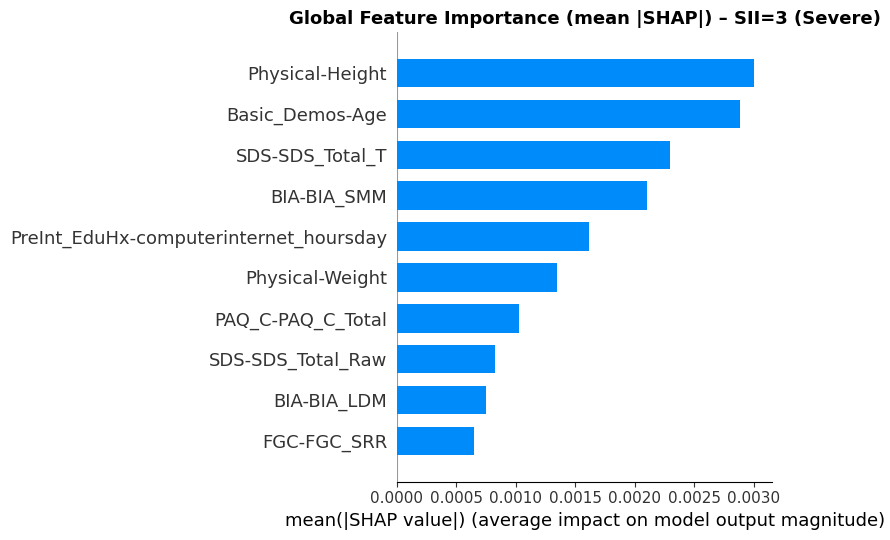

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_beeswarm.py:1033: UserWarning: Not enough data in bin #14 for feature Basic_Demos-Age, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_beeswarm.py:1033: UserWarning: Not enough data in bin #16 for feature Basic_Demos-Age, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_beeswarm.py:1033: UserWarning: Not enough data in bin #17 for feature Basic_Demos-Age, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(


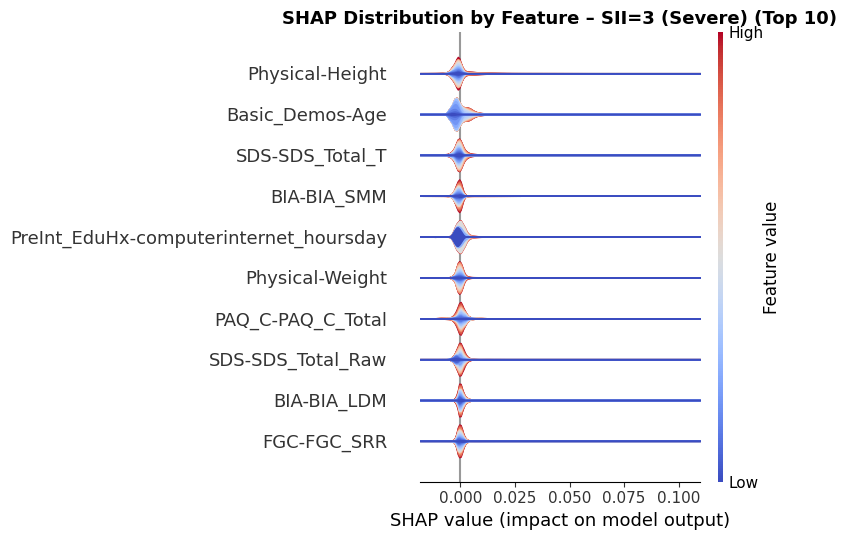

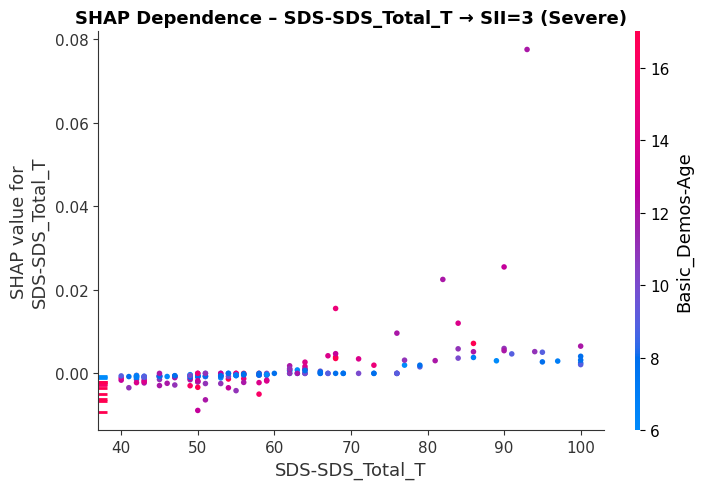

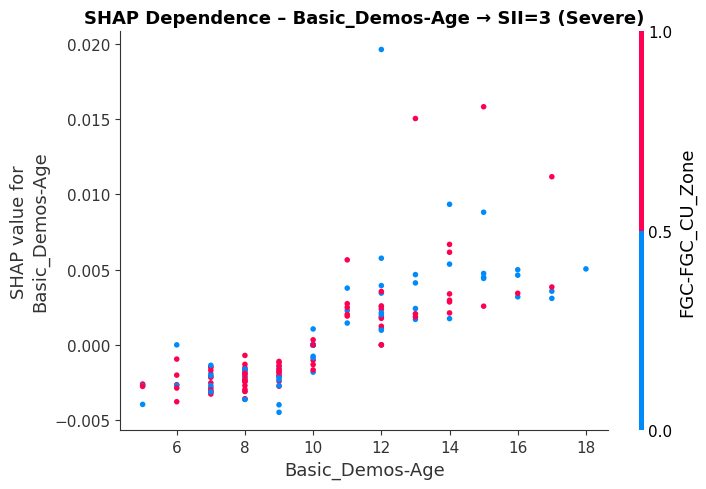

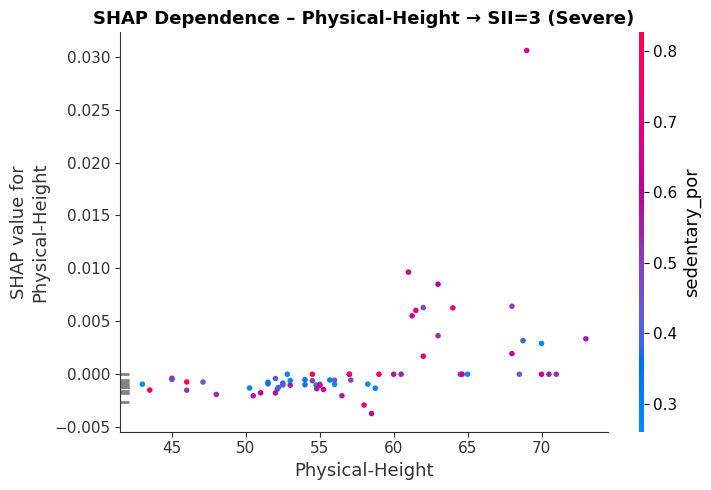


📋 Top 10 Features for SII=3 (Severe) (by mean |SHAP|):
   • Physical-Height                         : 0.0030
   • Basic_Demos-Age                         : 0.0029
   • SDS-SDS_Total_T                         : 0.0023
   • BIA-BIA_SMM                             : 0.0021
   • PreInt_EduHx-computerinternet_hoursday  : 0.0016
   • Physical-Weight                         : 0.0013
   • PAQ_C-PAQ_C_Total                       : 0.0010
   • SDS-SDS_Total_Raw                       : 0.0008
   • BIA-BIA_LDM                             : 0.0008
   • FGC-FGC_SRR                             : 0.0006


In [ ]:
# =====================================================
# 5. VẼ SHAP TẬP TRUNG CHO 1 CLASS + DỄ ĐỌC HƠN
# =====================================================
print("\n📊 Generating SHAP visualizations...")

# 5.1. Chọn 1 class để kể chuyện (ví dụ: class Severe = class cuối)
target_class_idx = n_classes - 1          # đổi sang index class anh muốn nếu cần
target_class_name = class_names[target_class_idx]
shap_vals_cls = shap_list[target_class_idx]   # (n_samples, n_features)

# -----------------------------------------------------
# 5.2. BARPLOT GLOBAL: mean(|SHAP|) – GIỐNG FEATURE IMPORTANCE
# -----------------------------------------------------
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_vals_cls,
    X_shap,                 # numpy array (n_samples, n_features)
    feature_names=feature_names,
    plot_type="bar",        # 🔴 dùng bar cho dễ đọc
    max_display=10,         # chỉ top 10 feature
    show=False
)
plt.title(
    f"Global Feature Importance (mean |SHAP|) – {target_class_name}",
    fontsize=13,
    fontweight='bold'
)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 5.3. LAYERED_VIOLIN CHO TOP K FEATURE (ĐỠ RỐI HƠN BEESWARM FULL)
# -----------------------------------------------------
K = 10
mean_abs_shap_cls = np.abs(shap_vals_cls).mean(axis=0)   # (n_features,)
top_idx = np.argsort(mean_abs_shap_cls)[-K:]             # index top K theo mean|SHAP|
top_feature_names = [feature_names[j] for j in top_idx]

# Lọc SHAP và X_shap tương ứng top K
shap_top = shap_vals_cls[:, top_idx]   # (n_samples, K)
X_shap_top = X_shap[:, top_idx]        # (n_samples, K)

plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_top,
    X_shap_top,
    feature_names=top_feature_names,
    max_display=K,
    plot_type="layered_violin",        # 🔴 gọn hơn dot beeswarm
    show=False
)
plt.title(
    f"SHAP Distribution by Feature – {target_class_name} (Top {K})",
    fontsize=13,
    fontweight='bold'
)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 5.4. DEPENDENCE PLOT CHO 3 FEATURE QUAN TRỌNG NHẤT
# -----------------------------------------------------
# chuẩn bị DataFrame cho dependence_plot
X_shap_df_full = pd.DataFrame(X_shap, columns=feature_names)

top3_idx = top_idx[-3:]   # 3 feature có mean|SHAP| lớn nhất trong top K

for j in top3_idx:
    feat_name = feature_names[j]
    shap.dependence_plot(
        feat_name,          # truyền tên feature
        shap_vals_cls,
        X_shap_df_full,     # DataFrame đủ cột
        feature_names=feature_names,
        show=False
    )
    plt.title(
        f"SHAP Dependence – {feat_name} → {target_class_name}",
        fontsize=13,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 5.5. IN BẢNG TOP 10 FEATURE (DÙNG CHO SLIDE TEXT)
# -----------------------------------------------------
print("\n📋 Top 10 Features for", target_class_name, "(by mean |SHAP|):")

feature_names_arr = np.array(feature_names)
top10_sorted_idx = np.argsort(mean_abs_shap_cls)[-10:][::-1]
for idx in top10_sorted_idx:
    print(f"   • {feature_names_arr[idx]:40s}: {mean_abs_shap_cls[idx]:.4f}")


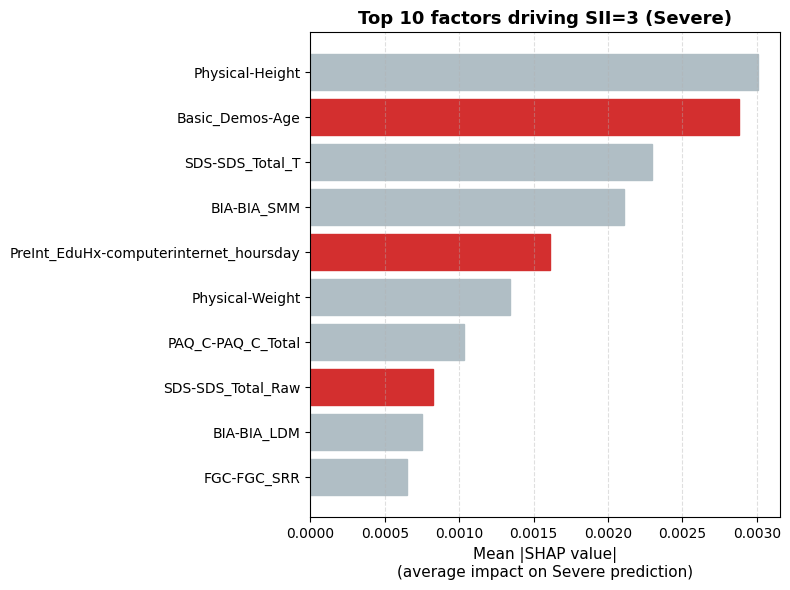

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# shap_vals_cls: (n_samples, n_features) – SHAP cho class Severe
mean_abs_shap_cls = np.abs(shap_vals_cls).mean(axis=0)  # (n_features,)

# Lấy Top 10 feature
n_top = 10
idx_top = np.argsort(mean_abs_shap_cls)[-n_top:]
scores_top = mean_abs_shap_cls[idx_top]
names_top = np.array(feature_names)[idx_top]

# Sắp xếp tăng dần để vẽ barh đẹp
order = np.argsort(scores_top)
scores_top = scores_top[order]
names_top = names_top[order]

plt.figure(figsize=(8, 6))
bars = plt.barh(names_top, scores_top)

plt.xlabel("Mean |SHAP value|\n(average impact on Severe prediction)", fontsize=11)
plt.title("Top 10 factors driving SII=3 (Severe)", fontsize=13, fontweight="bold")

# Highlight 2–3 feature "nhân vật chính" nếu muốn
highlight_feats = {"Basic_Demos-Age", "SDS-SDS_Total_Raw", "PreInt_EduHx-computerinternet_hoursday"}
for bar, name in zip(bars, names_top):
    if name in highlight_feats:
        bar.set_color("#D32F2F")  # đỏ đậm
    else:
        bar.set_color("#B0BEC5")  # xám nhạt

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18280\465199738.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_plot.groupby("bin")["proba_severe"].mean().reset_index()


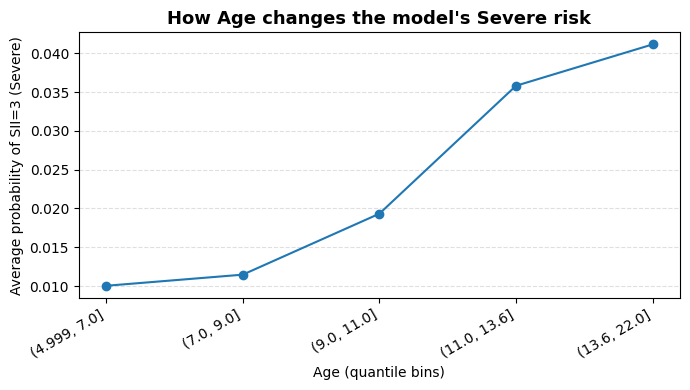

In [ ]:
import pandas as pd

# Chọn feature cần phân tích
feat = "Basic_Demos-Age"
severe_idx = 3  # index của class Severe trong predict_proba

# Lấy một tập dữ liệu khá lớn để phân tích (vd: full X_test)
X_plot = X_test[X_train.columns].copy()

# Ép numeric cho chắc
for col in X_plot.columns:
    X_plot[col] = pd.to_numeric(X_plot[col], errors="coerce")

# Predict proba Severe
proba_severe = xgb_model.predict_proba(X_plot)[:, severe_idx]

df_plot = pd.DataFrame({
    feat: X_plot[feat],
    "proba_severe": proba_severe
}).dropna()

# Chia Age thành 5 bin theo quantile
df_plot["bin"] = pd.qcut(df_plot[feat], 5)

# Tính proba trung bình theo bin
g = df_plot.groupby("bin")["proba_severe"].mean().reset_index()

plt.figure(figsize=(7, 4))
plt.plot(g["bin"].astype(str), g["proba_severe"], marker="o")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Average probability of SII=3 (Severe)")
plt.xlabel("Age (quantile bins)")
plt.title("How Age changes the model's Severe risk", fontsize=13, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


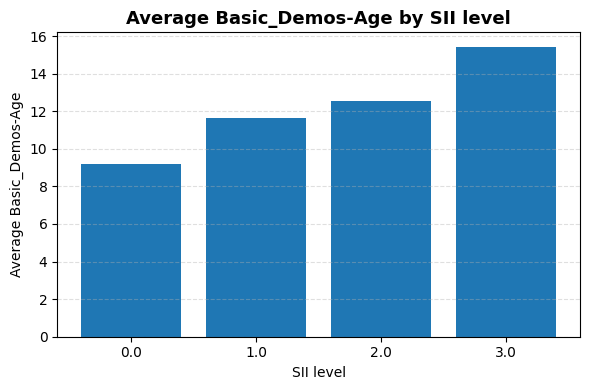

In [ ]:
# y_test: nhãn thật 0–3
feat = "Basic_Demos-Age"

df_avg = pd.DataFrame({
    "SII": y_test,
    feat: X_test[feat]
}).dropna()

avg_by_sii = df_avg.groupby("SII")[feat].mean()

plt.figure(figsize=(6, 4))
plt.bar(avg_by_sii.index.astype(str), avg_by_sii.values)
plt.xlabel("SII level")
plt.ylabel(f"Average {feat}")
plt.title(f"Average {feat} by SII level", fontsize=13, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


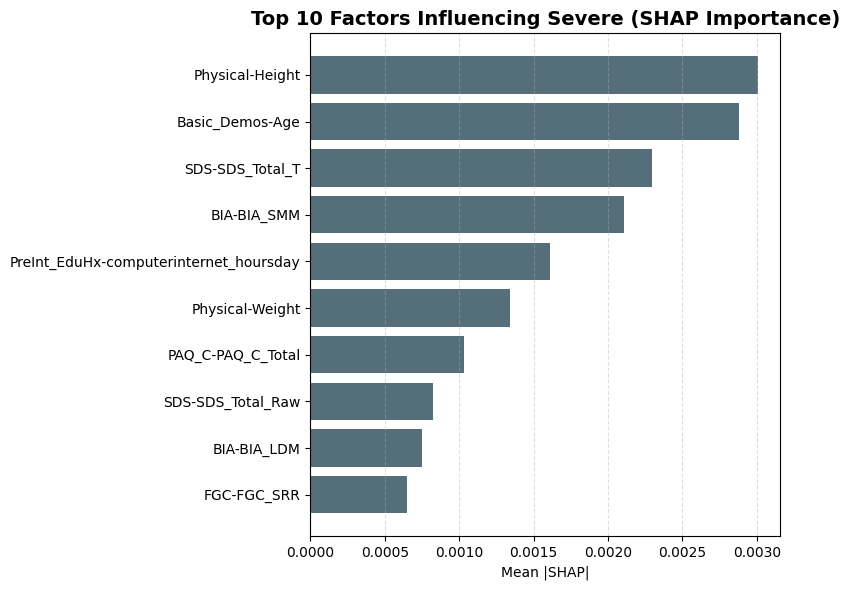

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean_abs_shap_cls = np.abs(shap_vals_cls).mean(axis=0)
idx_top = np.argsort(mean_abs_shap_cls)[-10:]
names_top = np.array(feature_names)[idx_top]
scores_top = mean_abs_shap_cls[idx_top]

order = np.argsort(scores_top)
scores_top = scores_top[order]
names_top = names_top[order]

plt.figure(figsize=(8,6))
plt.barh(names_top, scores_top, color="#546E7A")
plt.title("Top 10 Factors Influencing Severe (SHAP Importance)", fontsize=14, fontweight='bold')
plt.xlabel("Mean |SHAP|")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


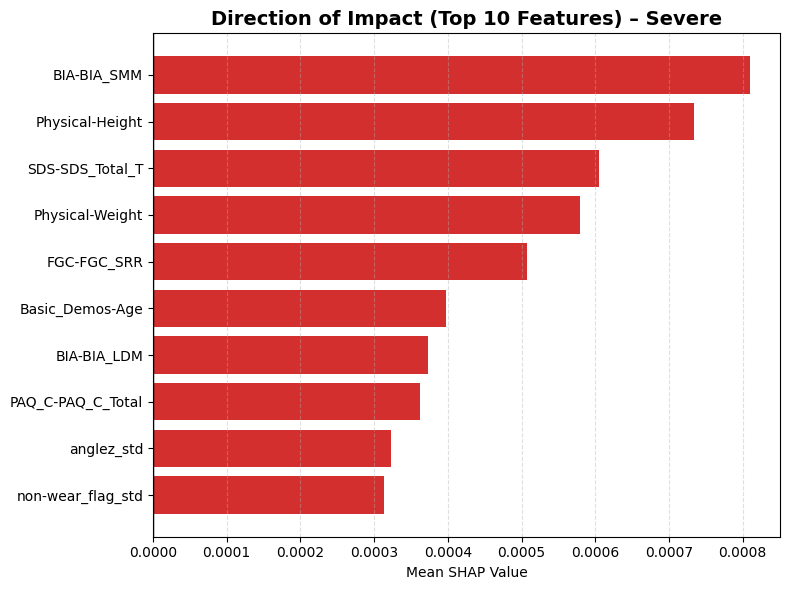

In [ ]:
mean_shap = shap_vals_cls.mean(axis=0)
idx_top = np.argsort(np.abs(mean_shap))[-10:]

names_top = np.array(feature_names)[idx_top]
scores_top = mean_shap[idx_top]

order = np.argsort(scores_top)
scores_top = scores_top[order]
names_top = names_top[order]

colors = ["#D32F2F" if v>0 else "#1976D2" for v in scores_top]

plt.figure(figsize=(8,6))
plt.barh(names_top, scores_top, color=colors)
plt.axvline(0, color="black", linewidth=1)
plt.title("Direction of Impact (Top 10 Features) – Severe", fontsize=14, fontweight='bold')
plt.xlabel("Mean SHAP Value")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18280\1352651343.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_plot.groupby("bin")["proba"].mean().reset_index()


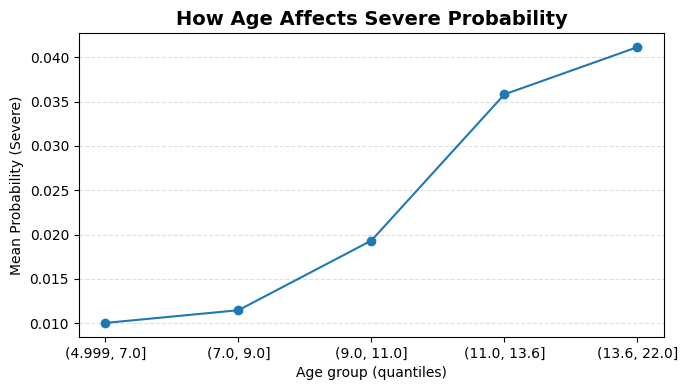

In [ ]:
feat = "Basic_Demos-Age"
proba_severe = xgb_model.predict_proba(X_test[X_train.columns])[:, 3]

df_plot = pd.DataFrame({
    feat: X_test[feat],
    "proba": proba_severe
}).dropna()

df_plot["bin"] = pd.qcut(df_plot[feat], 5)

g = df_plot.groupby("bin")["proba"].mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(g["bin"].astype(str), g["proba"], marker="o")
plt.title("How Age Affects Severe Probability", fontsize=14, fontweight="bold")
plt.xlabel("Age group (quantiles)")
plt.ylabel("Mean Probability (Severe)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


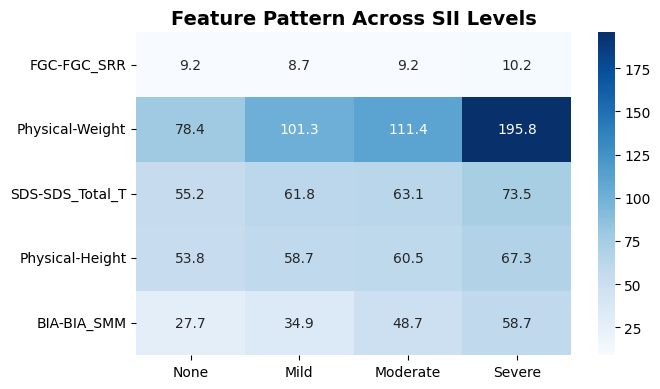

In [ ]:
import seaborn as sns

top5 = names_top[-5:]
df_heat = pd.DataFrame(index=top5, columns=["None","Mild","Moderate","Severe"])

for feat in top5:
    for cls in range(4):
        proba = xgb_model.predict_proba(X_test[X_train.columns])[:, cls]
        df_heat.loc[feat, df_heat.columns[cls]] = \
            X_test.assign(proba=proba).groupby(y_test)[feat].mean().iloc[cls]

plt.figure(figsize=(7,4))
sns.heatmap(df_heat.astype(float), annot=True, cmap="Blues", fmt=".1f")
plt.title("Feature Pattern Across SII Levels", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


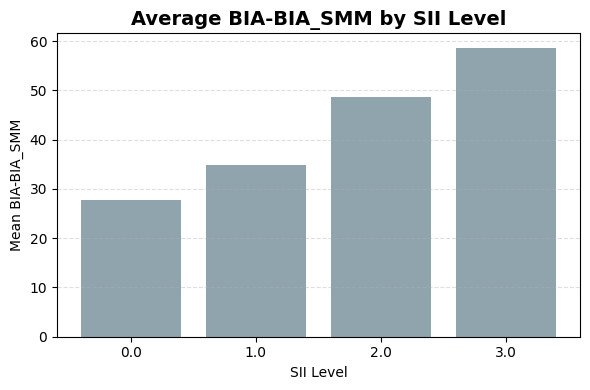

In [ ]:
df_avg = pd.DataFrame({
    "SII": y_test,
    feat: X_test[feat]
}).dropna()

avg_by_sii = df_avg.groupby("SII")[feat].mean()

plt.figure(figsize=(6,4))
plt.bar(avg_by_sii.index.astype(str), avg_by_sii.values, color="#90A4AE")
plt.title(f"Average {feat} by SII Level", fontsize=14, fontweight='bold')
plt.xlabel("SII Level")
plt.ylabel(f"Mean {feat}")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Top 10 features by built-in importance:
                               feature  importance
                       Basic_Demos-Age    0.042025
PreInt_EduHx-computerinternet_hoursday    0.022395
                           quarter_max    0.016503
                     SDS-SDS_Total_Raw    0.012556
                                 X_std    0.012142
                           quarter_50%    0.012010
                           anglez_mean    0.011951
                            anglez_75%    0.011831
                      FGC-FGC_SRR_Zone    0.011471
                   battery_voltage_max    0.011338


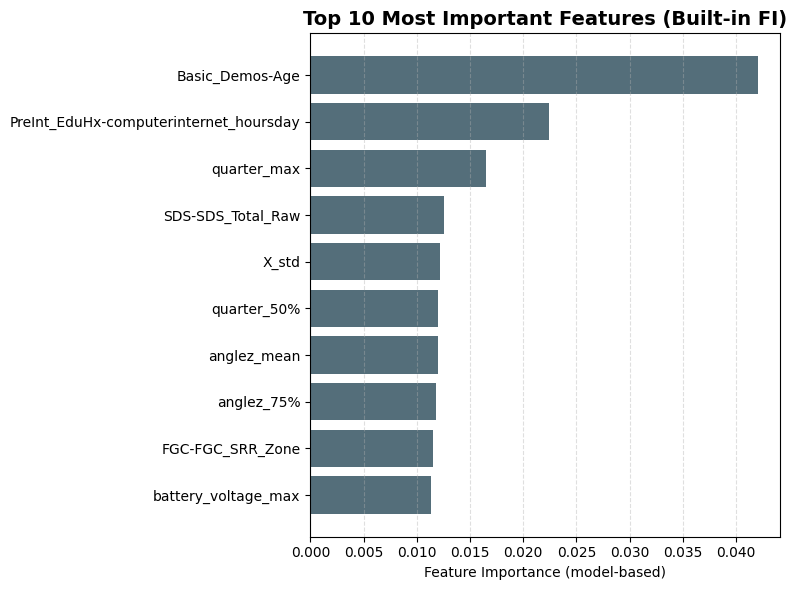

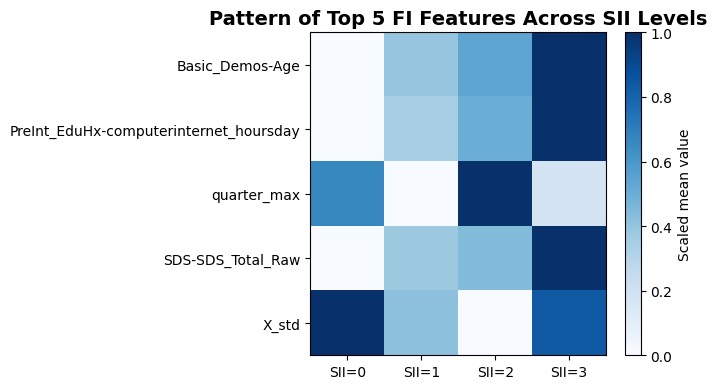


Using previously computed SHAP results for Direction plot...


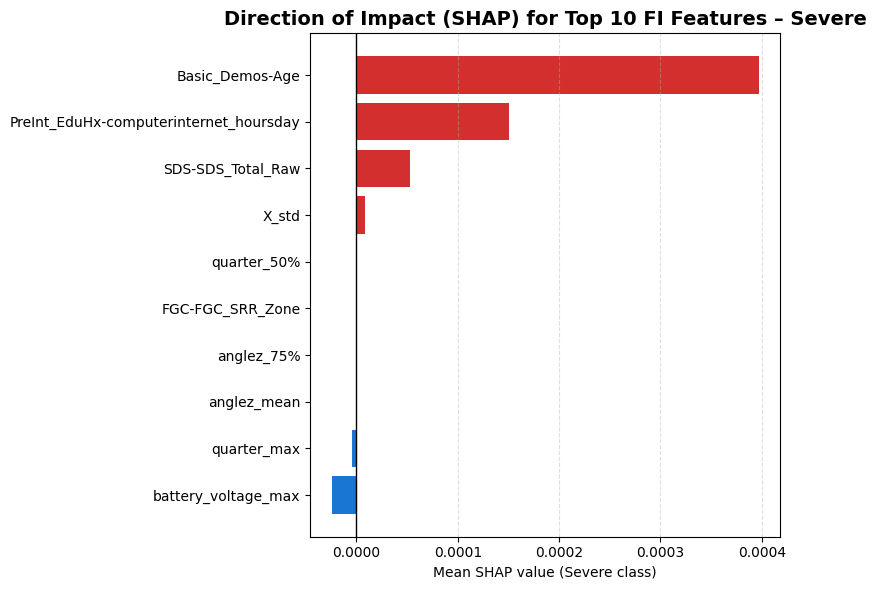

   ✗ dependence_plot failed for Basic_Demos-Age: index 200 is out of bounds for axis 0 with size 200
   ✗ dependence_plot failed for PreInt_EduHx-computerinternet_hoursday: index 200 is out of bounds for axis 0 with size 200


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18280\2472206020.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_line.groupby("bin")["proba_severe"].mean().reset_index()


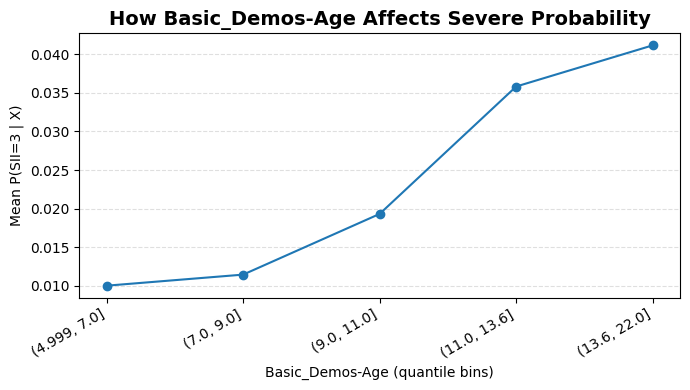

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ============================================
# CẤU HÌNH CƠ BẢN
# ============================================
feature_names = X_train.columns.tolist()
n_features = len(feature_names)

# Index class Severe trong predict_proba (đổi nếu khác)
severe_class_idx = 3

# Đảm bảo X_test cùng cột với X_train
X_test_aligned = X_test[feature_names].copy()

# ============================================
# 0. TÍNH BUILT-IN FEATURE IMPORTANCE (FI)
# ============================================
fi = xgb_model.feature_importances_  # (n_features,)
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": fi
}).sort_values("importance", ascending=False)

# Chọn top feature cho các biểu đồ
top10_feats = fi_df["feature"].head(10).tolist()
top5_feats  = fi_df["feature"].head(5).tolist()

print("Top 10 features by built-in importance:")
print(fi_df.head(10).to_string(index=False))


# ============================================
# 1) BAR CHART – TOP 10 FEATURE IMPORTANCE (FI)
# ============================================
top10_df = fi_df.head(10).copy()
top10_df = top10_df.sort_values("importance", ascending=True)  # sort để vẽ barh đẹp

plt.figure(figsize=(8, 6))
plt.barh(top10_df["feature"], top10_df["importance"], color="#546E7A")
plt.title("Top 10 Most Important Features (Built-in FI)", fontsize=14, fontweight="bold")
plt.xlabel("Feature Importance (model-based)")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# ============================================
# 2) HEATMAP – PATTERN TOP 5 FEATURE × 4 CLASS (RAW DATA)
# ============================================
# Tính giá trị trung bình của top5 feature theo từng lớp SII (0..3)
heat_values = np.full((len(top5_feats), 4), np.nan, dtype=float)

for i, feat in enumerate(top5_feats):
    for cls in range(4):
        mask = (y_test == cls)
        vals = X_test_aligned.loc[mask, feat].dropna().values
        heat_values[i, cls] = np.nan if vals.size == 0 else vals.mean()

# Chuẩn hoá nhẹ theo hàng cho dễ nhìn (option) - xử lý trường hợp tất cả NaN
row_min = np.nanmin(heat_values, axis=1, keepdims=True)
row_max = np.nanmax(heat_values, axis=1, keepdims=True)
# tránh chia cho 0
den = (row_max - row_min)
den[den == 0] = 1.0
scaled = (heat_values - row_min) / den

plt.figure(figsize=(7, 4))
im = plt.imshow(scaled, aspect="auto", cmap="Blues", vmin=0, vmax=1)

plt.yticks(range(len(top5_feats)), top5_feats)
plt.xticks(range(4), ["SII=0", "SII=1", "SII=2", "SII=3"]) 

plt.colorbar(im, label="Scaled mean value")
plt.title("Pattern of Top 5 FI Features Across SII Levels", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


# ============================================
# 3) SHAP – DIRECTION PLOT (+/-) CHO TOP 10 FEATURE FI (REUSE)
# ============================================
print("\nUsing previously computed SHAP results for Direction plot...")

try:
    # Nếu shap_list / shap_vals_severe đã được tính ở trên, dùng lại
    if 'shap_list' in globals() or 'shap_list' in locals():
        shap_list = shap_list  # reuse
    elif 'shap_raw' in globals() or 'shap_raw' in locals():
        # fallback: normalize shap_raw into shap_list like earlier code did
        arr = np.array(shap_raw)
        if isinstance(shap_raw, list):
            shap_list = shap_raw
        elif arr.ndim == 2:
            shap_list = [arr]
        elif arr.ndim == 3:
            n_samples, d1, d2 = arr.shape
            if d1 == n_features:
                shap_list = [arr[:, :, k] for k in range(d2)]
            elif d2 == n_features:
                shap_list = [arr[:, k, :] for k in range(d1)]
            else:
                raise ValueError(f"Unexpected SHAP array shape: {arr.shape}")
        else:
            raise ValueError(f"Unexpected SHAP array shape: {arr.shape}")
    else:
        raise NameError("No existing SHAP results found in workspace. Compute SHAP first or run previous SHAP cell.")

    if severe_class_idx >= len(shap_list):
        raise IndexError("severe_class_idx >= number of SHAP output classes in shap_list")

    # Ensure shap_vals_severe is numpy array shaped (n_samples, n_features)
    shap_vals_severe = np.array(shap_list[severe_class_idx])

    # Tính mean SHAP (có dấu) cho các feature
    mean_shap = np.nanmean(shap_vals_severe, axis=0)  # (n_features,)

    # Lấy đúng thứ tự của top10_feats từ FI (bảo vệ thiếu feature)
    idx_map = {f: i for i, f in enumerate(feature_names)}
    idx_top10 = [idx_map[f] for f in top10_feats if f in idx_map]
    mean_shap_top10 = mean_shap[idx_top10]
    names_top10 = np.array([f for f in top10_feats if f in idx_map])

    # Sắp xếp để vẽ
    order = np.argsort(mean_shap_top10)
    mean_shap_top10 = mean_shap_top10[order]
    names_top10 = names_top10[order]

    colors = ["#D32F2F" if v > 0 else "#1976D2" for v in mean_shap_top10]

    plt.figure(figsize=(8, 6))
    plt.barh(names_top10, mean_shap_top10, color=colors)
    plt.axvline(0, color="black", linewidth=1)
    plt.title("Direction of Impact (SHAP) for Top 10 FI Features – Severe", fontsize=14, fontweight="bold")
    plt.xlabel("Mean SHAP value (Severe class)")
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"⚠️  Could not reuse SHAP results: {e}")
    print("   → If you have already computed SHAP in an earlier cell, ensure variables named 'shap_list' or 'shap_raw' exist.")
    print("   → Otherwise run the SHAP computation cell first.")


# ============================================
# 4) SHAP DEPENDENCE PLOT – 2 FEATURE QUAN TRỌNG NHẤT
# ============================================
top2_for_dep = fi_df["feature"].head(2).tolist()

# nếu SHAP có sẵn thì vẽ dependence plot
if 'shap_vals_severe' in locals() and isinstance(shap_vals_severe, np.ndarray):
    # Ensure sampled DataFrame index matches shap arrays (0..n-1)
    if 'X_shap_df' in locals():
        X_shap_df_full = X_shap_df.reset_index(drop=True)
    else:
        # fallback: create from X_test_aligned sample using same sample_size
        X_shap_df_full = X_test_aligned.sample(n=min(500, len(X_test_aligned)), random_state=42).reset_index(drop=True)

    for feat_name in top2_for_dep:
        if feat_name in X_shap_df_full.columns:
            try:
                # Pass DataFrame with reset index and shap array with matching row-order
                shap.dependence_plot(
                    feat_name,
                    shap_vals_severe,
                    X_shap_df_full,
                    feature_names=X_shap_df_full.columns,
                    show=False
                )
                plt.title(f"SHAP Dependence – {feat_name} → Severe", fontsize=14, fontweight="bold")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"   ✗ dependence_plot failed for {feat_name}: {e}")
        else:
            print(f"   ✗ feature {feat_name} not in SHAP sample; skipping dependence_plot")
else:
    print("   ✗ SHAP values not available; skipping dependence plots.")


# ============================================
# 5) LINE CHART – FEATURE VALUE → PROBABILITY SEVERE
# ============================================
feat_line = fi_df["feature"].iloc[0]

proba_all = xgb_model.predict_proba(X_test_aligned)[:, severe_class_idx]
# make sure alignment of index with y_test
df_line = pd.DataFrame({
    feat_line: X_test_aligned[feat_line],
    "proba_severe": proba_all,
    "SII": y_test
}).dropna()

# Chia thành 5 bin theo quantile
df_line["bin"] = pd.qcut(df_line[feat_line], 5, duplicates="drop")

g = df_line.groupby("bin")["proba_severe"].mean().reset_index()

plt.figure(figsize=(7, 4))
plt.plot(g["bin"].astype(str), g["proba_severe"], marker="o")
plt.xticks(rotation=30, ha="right")
plt.title(f"How {feat_line} Affects Severe Probability", fontsize=14, fontweight="bold")
plt.xlabel(f"{feat_line} (quantile bins)")
plt.ylabel("Mean P(SII=3 | X)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

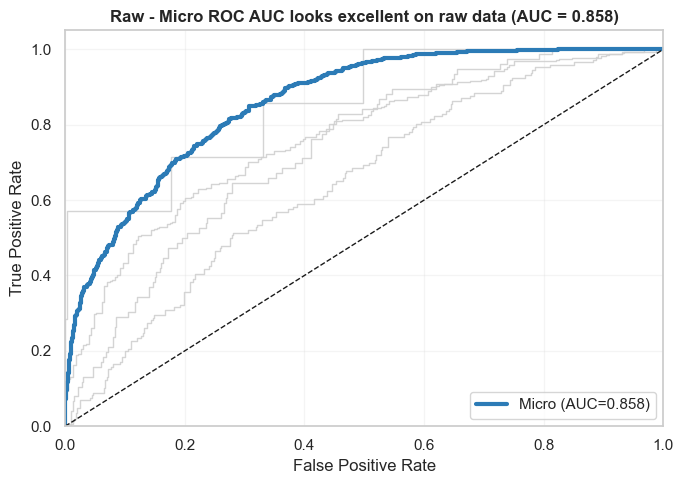

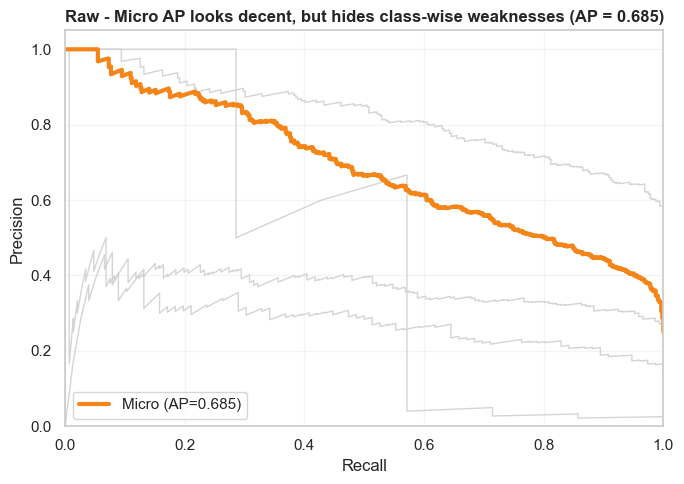

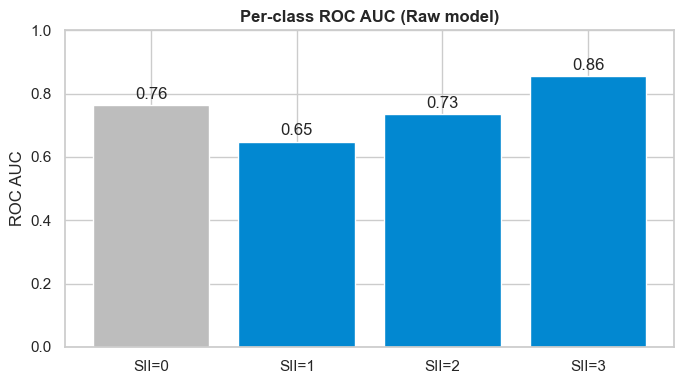

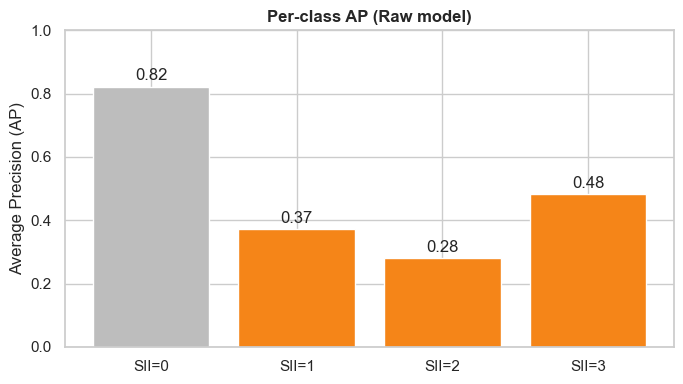


Per-class ROC AUC:
  SII=0: 0.764
  SII=1: 0.648
  SII=2: 0.735
  SII=3: 0.855

Per-class AP:
  SII=0: 0.822
  SII=1: 0.372
  SII=2: 0.280
  SII=3: 0.482


In [80]:
# Explanatory Global vs Per-class performance (ROC / PR / per-class AUC/AP)
# Uses: y_test, xgb_model, X_test or X_test_aligned; expects multi-class with labels [0,1,2,3]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

plt.rcParams.update({'figure.max_open_warning': 0})


def explanatory_roc_pr(y_true, y_proba, labels=[0,1,2,3], title_prefix='Raw'):
    """Plot explanatory ROC and PR: class-wise gray curves, micro-average bold.
    Also return per-class ROC AUC and AP (dicts).
    y_proba: array-like (n_samples, n_classes)
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n_classes = y_proba.shape[1]
    classes = labels[:n_classes]

    # Binarize
    y_bin = label_binarize(y_true, classes=classes)

    # --- ROC ---
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i, c in enumerate(classes):
        try:
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        except Exception:
            fpr[i], tpr[i], roc_auc[i] = np.array([0,1]), np.array([0,1]), 0.0

    fpr['micro'], tpr['micro'], _ = roc_curve(y_bin.ravel(), y_proba.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # Plot explanatory ROC
    plt.figure(figsize=(7,5))
    # class-wise gray
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color='#D0D0D0', lw=1, alpha=0.9)
    # micro bold
    plt.plot(fpr['micro'], tpr['micro'], color='#2C7BB6', lw=3, label=f"Micro (AUC={roc_auc['micro']:.3f})")
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f"{title_prefix} - Micro ROC AUC looks excellent on raw data (AUC = {roc_auc['micro']:.3f})", fontsize=12, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    # --- Precision-Recall ---
    precision = dict(); recall = dict(); avg_prec = dict()
    for i in range(n_classes):
        try:
            precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
            avg_prec[i] = average_precision_score(y_bin[:, i], y_proba[:, i])
        except Exception:
            precision[i], recall[i], avg_prec[i] = np.array([0,1]), np.array([1,0]), 0.0

    precision['micro'], recall['micro'], _ = precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    avg_prec['micro'] = average_precision_score(y_bin, y_proba, average='micro')

    # Plot explanatory PR
    plt.figure(figsize=(7,5))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], color='#D0D0D0', lw=1, alpha=0.9)
    plt.plot(recall['micro'], precision['micro'], color='#F58518', lw=3, label=f"Micro (AP={avg_prec['micro']:.3f})")
    plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f"{title_prefix} - Micro AP looks decent, but hides class-wise weaknesses (AP = {avg_prec['micro']:.3f})", fontsize=12, fontweight='bold')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Return per-class metrics
    per_class_roc = {int(classes[i]): float(roc_auc[i]) for i in range(n_classes)}
    per_class_ap = {int(classes[i]): float(avg_prec[i]) for i in range(n_classes)}
    return per_class_roc, per_class_ap


def plot_per_class_bars(metric_dict, metric_name='ROC AUC', title=None, color_main='#0288D1'):
    labels = sorted(metric_dict.keys())
    vals = [metric_dict[l] for l in labels]
    colors = ['#BDBDBD' if l==0 else color_main for l in labels]
    plt.figure(figsize=(7,4))
    plt.bar([f"SII={int(l)}" for l in labels], vals, color=colors)
    plt.ylim(0,1)
    for i,v in enumerate(vals):
        plt.text(i, v+0.02, f"{v:.2f}", ha='center')
    if title is None:
        title = f"Per-class {metric_name}"
    plt.title(title, fontsize=12, fontweight='bold')
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.show()


def plot_stage_auc_ap(stage_results, metric='roc', label_prefix=''):
    """stage_results: list of tuples (y_true, y_proba, label)
       metric: 'roc' or 'ap'
    """
    stage_labels = [lbl for _,_,lbl in stage_results]
    values = []
    for y_true, y_proba, _ in stage_results:
        per_roc, per_ap = explanatory_roc_pr_compute(y_true, y_proba)
        if metric=='roc':
            # combined metric: recall for SII>=1 or mean per-class? We'll use mean AUC for SII>=1
            vals = [per_roc.get(1,0), per_roc.get(2,0), per_roc.get(3,0)]
            values.append(np.mean(vals))
        else:
            vals = [per_ap.get(1,0), per_ap.get(2,0), per_ap.get(3,0)]
            values.append(np.mean(vals))
    plt.figure(figsize=(8,4))
    plt.plot(stage_labels, values, marker='o', color='#0288D1')
    for x,yv in zip(stage_labels, values):
        plt.text(x, yv+0.01, f"{yv:.2f}", ha='center')
    tmap = {'roc': 'Mean AUC for SII 1-3', 'ap': 'Mean AP for SII 1-3'}
    plt.title(f"{label_prefix} - {tmap.get(metric, metric)} across stages", fontsize=12, fontweight='bold')
    plt.ylim(0,1)
    plt.ylabel(tmap.get(metric, metric))
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# helper to compute per-class dicts without plotting (used by stage plot)
def explanatory_roc_pr_compute(y_true, y_proba, labels=[0,1,2,3]):
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n_classes = y_proba.shape[1]
    classes = labels[:n_classes]
    y_bin = label_binarize(y_true, classes=classes)
    roc_auc = {}
    avg_prec = {}
    for i,c in enumerate(classes):
        try:
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
            roc_auc[i] = auc(fpr, tpr)
        except Exception:
            roc_auc[i] = 0.0
        try:
            avg_prec[i] = average_precision_score(y_bin[:, i], y_proba[:, i])
        except Exception:
            avg_prec[i] = 0.0
    return {int(classes[i]):float(roc_auc[i]) for i in range(len(classes))}, {int(classes[i]):float(avg_prec[i]) for i in range(len(classes))}


# === Run for RAW model in this notebook ===
try:
    # Try to get probability predictions
    if 'y_pred_proba' in globals() or 'y_pred_proba' in locals():
        y_proba = y_pred_proba
    else:
        # fallback: compute from model and aligned test set
        try:
            y_proba = xgb_model.predict_proba(X_test_aligned)
        except Exception:
            y_proba = xgb_model.predict_proba(X_test)
    y_true = y_test

    per_class_roc, per_class_ap = explanatory_roc_pr(y_true, y_proba, labels=[0,1,2,3], title_prefix='Raw')

    # Per-class bar charts
    plot_per_class_bars(per_class_roc, metric_name='ROC AUC', title='Per-class ROC AUC (Raw model)')
    plot_per_class_bars(per_class_ap, metric_name='Average Precision (AP)', title='Per-class AP (Raw model)', color_main='#F58518')

    # Print values
    print('\nPer-class ROC AUC:')
    for k,v in per_class_roc.items():
        print(f"  SII={k}: {v:.3f}")
    print('\nPer-class AP:')
    for k,v in per_class_ap.items():
        print(f"  SII={k}: {v:.3f}")

except Exception as e:
    print('Could not compute explanatory ROC/PR for raw model:', e)
    print('Ensure xgb_model, X_test_aligned and y_test exist and model supports predict_proba.')

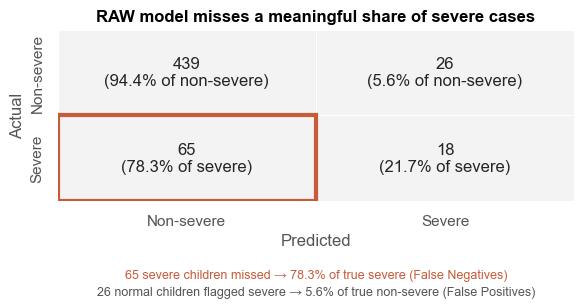

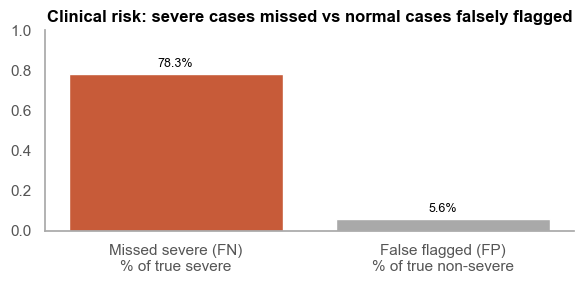

,Metric,Value
0,True Severe (n),83
1,True Non-severe (n),465
2,False Negatives (n),65
3,False Positives (n),26


In [95]:
# Error analysis: Severe vs Non-severe (2x2 confusion matrix + explanatory charts)
# Grouping: Non-severe = SII 0-1, Severe = SII 2-3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

# Style tối giản, nền trắng
sns.set(style='white')

# ===== PALETTE CHO PHẦN PROBLEM =====
neutral_grey_light = "#F3F3F3"  # nền ô matrix
neutral_grey_dark  = "#A9A9A9"  # đường, bar context
neutral_text       = "#555555"  # chữ trục, label
accent_problem     = "#C75B39"  # cam/đỏ trầm = màu cảnh báo chính

try:
    y_true = np.asarray(y_test)
    y_pred = np.asarray(y_pred_test)

    # Binary mapping: 0 = Non-severe (0-1), 1 = Severe (2-3)
    true_bin = (y_true >= 2).astype(int)
    pred_bin = (y_pred >= 2).astype(int)

    # Confusion matrix 2x2: rows = true, cols = pred
    cm = confusion_matrix(true_bin, pred_bin, labels=[0, 1])
    # cm layout:
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = cm.ravel()

    total_severe    = int((true_bin == 1).sum())
    total_nonsevere = int((true_bin == 0).sum())

    fn_pct = (fn / total_severe) if total_severe > 0 else 0.0
    fp_pct = (fp / total_nonsevere) if total_nonsevere > 0 else 0.0

    # ----- Annotations (count + % of true-row) -----
    annot = np.empty_like(cm).astype(object)

    # Row 0 = True Non-severe
    if total_nonsevere > 0:
        annot[0, 0] = f"{int(tn)}\n({tn/total_nonsevere:.1%} of non-severe)"
        annot[0, 1] = f"{int(fp)}\n({fp/total_nonsevere:.1%} of non-severe)"
    else:
        annot[0, 0] = f"{int(tn)}"
        annot[0, 1] = f"{int(fp)}"

    # Row 1 = True Severe
    if total_severe > 0:
        annot[1, 0] = f"{int(fn)}\n({fn/total_severe:.1%} of severe)"
        annot[1, 1] = f"{int(tp)}\n({tp/total_severe:.1%} of severe)"
    else:
        annot[1, 0] = f"{int(fn)}"
        annot[1, 1] = f"{int(tp)}"

    df_cm = pd.DataFrame(
        cm,
        index=['Non-severe', 'Severe'],
        columns=['Non-severe', 'Severe']
    )

    # ========= CONFUSION MATRIX HEATMAP =========
    plt.figure(figsize=(6, 4))

    # Colormap 1 màu xám nhạt → mọi ô cùng màu, không ô nào đen hơn
    cmap = ListedColormap([neutral_grey_light])

    ax = sns.heatmap(
        df_cm,
        annot=annot,
        fmt='',
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='white'
    )

    ax.set_title(
        'RAW model misses a meaningful share of severe cases',
        fontsize=12,
        fontweight='bold',
        color='black'
    )
    ax.set_xlabel('Predicted', color=neutral_text)
    ax.set_ylabel('Actual',   color=neutral_text)

    # Tô lại màu tick & label cho nhẹ nhàng
    ax.tick_params(colors=neutral_text)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_color(neutral_text)

    # Highlight FN cell (True Severe & Pred Non-severe) - row=1, col=0
    rect = patches.Rectangle(
        (0, 1), 1, 1,
        fill=False,
        edgecolor=accent_problem,
        linewidth=3
    )
    ax.add_patch(rect)

    # Giải thích: ưu tiên FN (nguy cơ cao) bằng accent, FP để xám
# Giải thích: ưu tiên FN (nguy cơ cao) bằng accent, FP để xám
    plt.text(
    0.5, -0.45,  # ↓↓ giảm xuống (từ -0.25 → -0.35)
    f"{fn} severe children missed → {fn_pct:.1%} of true severe (False Negatives)",
    ha='center',
    color=accent_problem,
    transform=ax.transAxes,
    fontsize=9
)

    plt.text(
    0.5, -0.55,  # ↓↓ giảm xuống (từ -0.38 → -0.55)
    f"{fp} normal children flagged severe → {fp_pct:.1%} of true non-severe (False Positives)",
    ha='center',
    color=neutral_text,
    transform=ax.transAxes,
    fontsize=9
)

    plt.tight_layout()
    plt.show()

    # ========= BAR CHART: FN% vs FP% =========
    plt.figure(figsize=(6, 3))

    labels = [
        'Missed severe (FN)\n% of true severe',
        'False flagged (FP)\n% of true non-severe'
    ]
    values = [fn_pct, fp_pct]

    # Chỉ FN dùng accent, FP dùng xám để giữ 1 accent color
    bar_colors = [accent_problem, neutral_grey_dark]

    bars = plt.bar(labels, values, color=bar_colors)
    plt.ylim(0, 1)

    for bar, val in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            val + 0.02,
            f"{val:.1%}",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )

    plt.title(
        'Clinical risk: severe cases missed vs normal cases falsely flagged',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

    # Tối giản trục, giữ xám cho context
    ax2 = plt.gca()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_color(neutral_grey_dark)
    ax2.spines['bottom'].set_color(neutral_grey_dark)
    ax2.tick_params(axis='y', colors=neutral_text)
    ax2.tick_params(axis='x', colors=neutral_text)

    plt.tight_layout()
    plt.show()

    # Optional: counts table
    summary2 = pd.DataFrame({
        'Metric': ['True Severe (n)', 'True Non-severe (n)', 'False Negatives (n)', 'False Positives (n)'],
        'Value': [total_severe, total_nonsevere, int(fn), int(fp)]
    })
    display(summary2)

except NameError as e:
    print('Required variables not found in workspace:', e)
    print('Make sure `y_test` and `y_pred_test` are defined for RAW model and run the prior cells.')
except Exception as e:
    print('Error while computing Severe vs Non-severe confusion analysis:', e)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18280\3742365958.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates, y=labels, ax=ax, palette='Blues_d')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18280\3742365958.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates, y=labels, ax=ax, palette='Blues_d')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18280\3742365958.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates, y=labels, ax=ax, palette='Blues_d')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18280\3742365958.py:94: Fu

Saved figure to: d:\HỌC KỲ V\Chuẩn bị dữ liệu và Visualization\Project_final\Notebooks\Notebooks\figures\sii_subgroups_raw.png


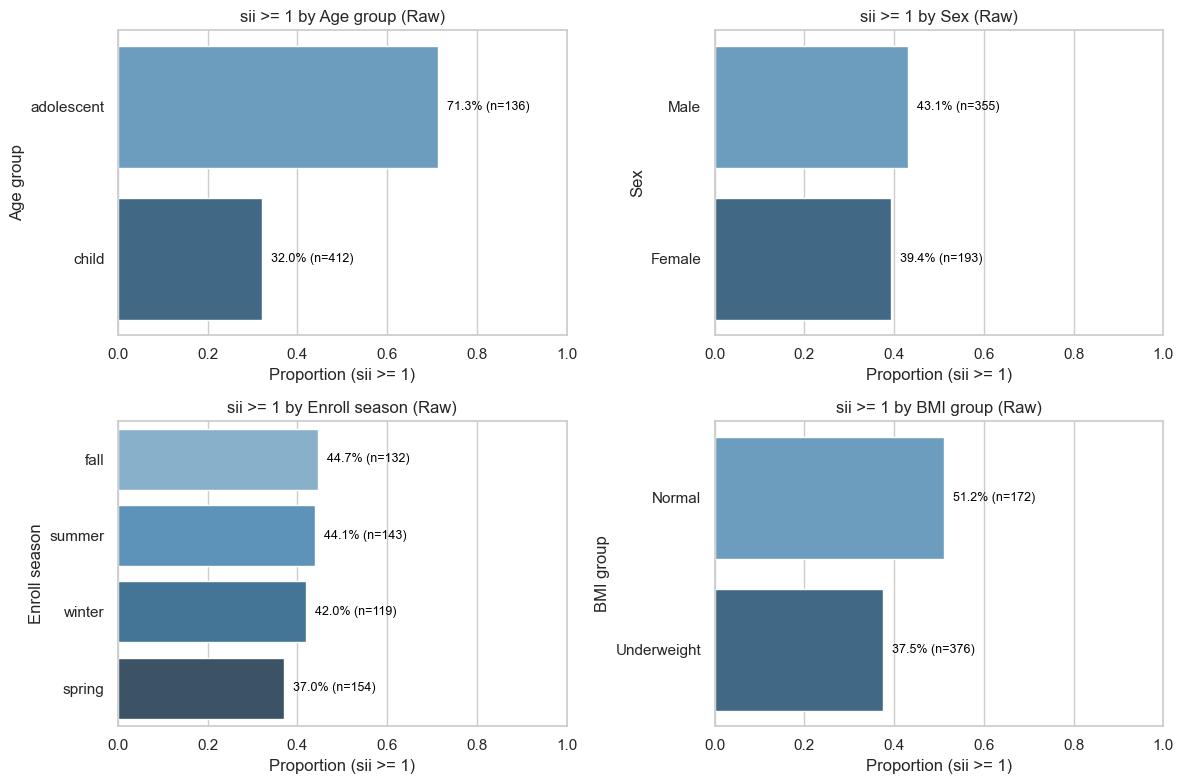

--- Age group ---


,age_group,rate,n
0,adolescent,0.713235,136
1,child,0.320388,412


Saved table to: d:\HỌC KỲ V\Chuẩn bị dữ liệu và Visualization\Project_final\Notebooks\Notebooks\figures\sii_table_age_group.csv
--- Sex ---


,sex,rate,n
1,Male,0.430986,355
0,Female,0.393782,193


Saved table to: d:\HỌC KỲ V\Chuẩn bị dữ liệu và Visualization\Project_final\Notebooks\Notebooks\figures\sii_table_sex.csv
--- Enroll season ---


,enroll_season,rate,n
0,fall,0.446970,132
2,summer,0.440559,143
3,winter,0.420168,119
1,spring,0.370130,154


Saved table to: d:\HỌC KỲ V\Chuẩn bị dữ liệu và Visualization\Project_final\Notebooks\Notebooks\figures\sii_table_enroll_season.csv
--- BMI group ---


,bmi_group,rate,n
0,Normal,0.511628,172
1,Underweight,0.375000,376


Saved table to: d:\HỌC KỲ V\Chuẩn bị dữ liệu và Visualization\Project_final\Notebooks\Notebooks\figures\sii_table_bmi_group.csv


In [98]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
sns.set(style="whitegrid")

# Path to raw dataset (only raw will be used)
raw_path = r"d:\HỌC KỲ V\Chuẩn bị dữ liệu và Visualization\Project_final\Data\processed\test_cleaned.csv"

# Read raw CSV
df = pd.read_csv(raw_path).copy()

# Create and clean subgroup columns
# Age group: child <13, adolescent >=13, unknown if missing
df['age'] = df.get('Basic_Demos-Age')
df['age_group'] = df['age'].apply(lambda x: 'child' if pd.notnull(x) and x < 13 else ('adolescent' if pd.notnull(x) else 'unknown'))
# Sex mapping: 0->Male, 1->Female, else Unknown
if 'Basic_Demos-Sex' in df.columns:
    df['sex'] = df.get('Basic_Demos-Sex').map({0: 'Male', 1: 'Female'})
    df['sex'] = df['sex'].fillna('Unknown')
else:
    df['sex'] = 'Unknown'
# Enroll season (as-is)
if 'Basic_Demos-Enroll_Season' in df.columns:
    df['enroll_season'] = df.get('Basic_Demos-Enroll_Season').astype(str).replace('nan', 'Unknown')
else:
    df['enroll_season'] = 'Unknown'
# BMI groups from BIA-BIA_BMI if available
if 'BIA-BIA_BMI' in df.columns:
    df['bmi'] = df['BIA-BIA_BMI']
    def bmi_cat(x):
        try:
            if pd.isna(x):
                return 'Unknown'
        except Exception:
            return 'Unknown'
        try:
            xv = float(x)
        except Exception:
            return 'Unknown'
        if xv < 18.5:
            return 'Underweight'
        elif xv < 25:
            return 'Normal'
        elif xv < 30:
            return 'Overweight'
        else:
            return 'Obese'
    df['bmi_group'] = df['bmi'].apply(bmi_cat)
else:
    df['bmi_group'] = 'Unknown'

# sii positive indicator (sii >= 1)
df['sii_pos'] = (df.get('sii', pd.Series([np.nan]*len(df))) >= 1).astype(int)

# List of subgroup columns to plot (display order key -> column name)
subgroups = {
    'Age group': 'age_group',
    'Sex': 'sex',
    'Enroll season': 'enroll_season',
    'BMI group': 'bmi_group',
}

# Compute rates for each subgroup and plot (one subplot per subgroup)
results = {}
for name, col in subgroups.items():
    if col not in df.columns:
        results[name] = pd.DataFrame(columns=[col, 'rate', 'n'])
        continue
    grp = df.groupby(col)['sii_pos'].agg(['mean', 'count']).reset_index().rename(columns={'mean':'rate','count':'n'})
    # Sort by rate descending for plotting
    grp = grp.sort_values('rate', ascending=False)
    results[name] = grp

# Plotting layout
n_plots = len(subgroups)
ncols = 2
nrows = (n_plots + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = np.array(axes).reshape(-1)

for ax_idx, (name, col) in enumerate(subgroups.items()):
    ax = axes[ax_idx]
    grp = results[name]
    if grp.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_axis_off()
        continue
    labels = grp[col].astype(str).tolist()
    rates = grp['rate'].fillna(0).tolist()
    counts = grp['n'].tolist()
    sns.barplot(x=rates, y=labels, ax=ax, palette='Blues_d')
    ax.set_xlim(0, 1)
    ax.set_xlabel('Proportion (sii >= 1)')
    ax.set_ylabel(name)
    ax.set_title(f'sii >= 1 by {name} (Raw)')
    # annotate counts and percents
    for i, (r, c) in enumerate(zip(rates, counts)):
        xpos = r + 0.02 if r < 0.9 else r - 0.18
        ax.text(xpos, i, f'{r:.1%} (n={int(c)})', va='center', color='black', fontsize=9)

# Hide any unused subplots
for j in range(len(subgroups), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# Save figure to Notebooks/figures
import os
out_dir = os.path.join(os.getcwd(), 'Notebooks', 'figures')
os.makedirs(out_dir, exist_ok=True)
fig_path = os.path.join(out_dir, 'sii_subgroups_raw.png')
fig.savefig(fig_path, dpi=200, bbox_inches='tight')
print(f"Saved figure to: {fig_path}")
plt.show()

# Display numeric tables for each subgroup for reference and save to CSV
for name, grp in results.items():
    print(f'--- {name} ---')
    display(grp)
    safe_name = name.lower().replace(' ', '_')
    csv_path = os.path.join(out_dir, f'sii_table_{safe_name}.csv')
    grp.to_csv(csv_path, index=False)
    print(f"Saved table to: {csv_path}")


**4.2 Theo subgroup (age / sex / others)**

Giả định & hướng tiếp cận:

- Chỉ phân tích `Raw` (file `test_cleaned.csv`) — hiện chưa có phần `After prep` để so sánh.
- `sii` được xem là dương tính khi `sii >= 1`.
- Age group: `child` < 13, `adolescent` >= 13.
- Sex mapping: `0` -> `Male`, `1` -> `Female`.
- Các nhóm bổ sung được vẽ: `Enroll season` (từ `Basic_Demos-Enroll_Season`) và `BMI group` (từ `BIA-BIA_BMI`, nếu có).

Mục tiêu: vẽ bar chart tỷ lệ mẫu có `sii >= 1` theo các subgroup (Age group, Sex, Enroll season, BMI group) cho dữ liệu Raw.